# Extract all fitted params from many dates in OGA butler

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-02-01
- last update : 2024-02-19
- affiliation : IJCLab/IN2P3/CNRS
- w_2024_07
- Spectractor v3.0.3
- N = 149.5

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.colors as mcolors
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys,re

In [3]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2024_07/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2024_07/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [6]:
sys.path.append("../lib")
from libanaspectra import *
from config_spectractor import *

In [7]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [8]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [9]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

In [10]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")

Text(0.5, 1.0, 'Total Rubin-LSST filter throughput')

In [11]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [12]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201/20240201T144534Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5/20240215T190316Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150/2024

## Config

### Config collection

In [13]:
# work done 5th Feb 2024
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsPTC_rebin2_240201"
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201"

#work done 16th Feb 2024
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5/20240215T190316Z"
my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsPTC_rebin2_240218_N149.5"

### Config Auxtel

In [14]:
spectractor.__path__[0]

'/home/d/dagoret/repos/repos_w_2024_07/Spectractor/lib/python/spectractor'

In [15]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_path = "/home/d/dagoret/repos/repos_w_2024_07/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [16]:
print(config_fullpath)

/home/d/dagoret/repos/repos_w_2024_07/Spectractor/lib/python/spectractor/../config/auxtel.ini


In [17]:
print(parameters.SPECTRACTOR_ATMOSPHERE_SIM)

getobsatmo


In [18]:
parameters.OBS_NAME

'CTIO'

In [19]:
parameters.CONFIG_DIR

'../config/'

In [20]:
# in w_2023_44 I had to load explicitely
# in w_2024_07 Apparently the parameters is well loaded and explicit call to load_config fails
load_config_local(config_fullpath)

parameters.SPECTRACTOR_ATMOSPHERE_SIM =  getobstamo


### Config Telescope Throughtput

In [21]:
throughput_fullpath = os.path.join(spectractor.__path__[0],parameters.THROUGHPUT_DIR)
throughput_fullfilename = os.path.join(throughput_fullpath,throughput_filename)

In [22]:
tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 

In [23]:
parameters.THROUGHPUT_DIR = throughput_fullpath 
parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = throughput_filename
print(parameters.THROUGHPUT_DIR )
print(parameters.OBS_FULL_INSTRUMENT_TRANSMISSON)

/home/d/dagoret/repos/repos_w_2024_07/Spectractor/lib/python/spectractor/simulation/AuxTelThroughput/
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [24]:
%matplotlib inline
tel = TelescopeTransmission()
tel.plot_transmission()

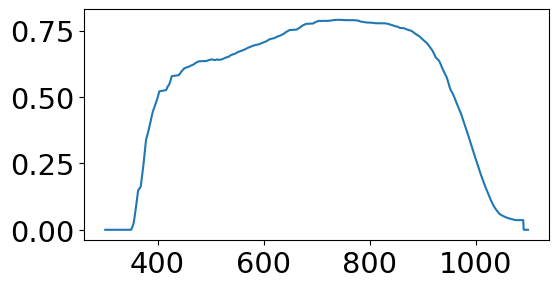

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel.transmission(tel_lambdas))

### Config disperser

In [26]:
disp = dispersers.Hologram("holo4_003")

## Load config filename for Auxtel

In [27]:
#load_config(config_fullpath)

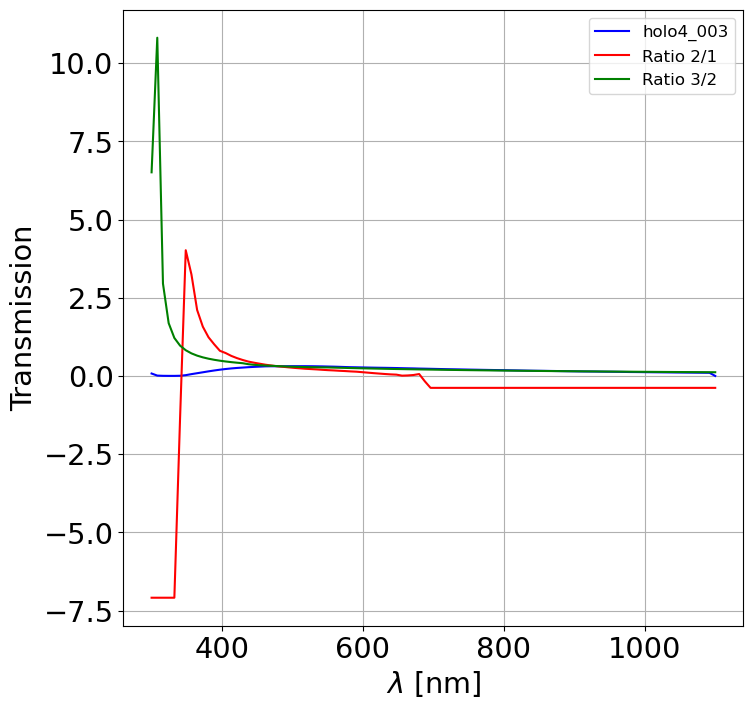

In [28]:
disp.plot_transmission()

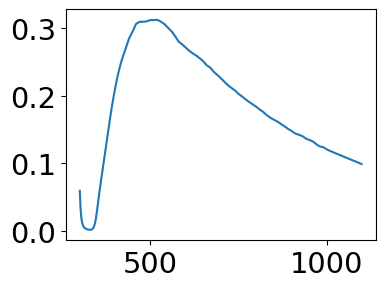

In [29]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,disp.transmission(tel_lambdas))

## Check the presence of the spectra

### select the date of observation in 2024

- Split in 4 parts because too many files open

In [30]:
# Middle of the year 2024
ALL_DATEOBS = np.array([20240129, 20240130, 20240131, 20240205, 20240206, 20240207,
                        20240212, 20240213, 20240214, 20240215])
file_out_allfittedparams = "out_allfittedparams_selected_29jan-15feb2024_N149.5.csv"
file_out_zp = "zp_selected_29jan-15feb2024_N149.5.csv"

In [31]:
len(ALL_DATEOBS)

10

## Access to spectra using the butler

In [32]:
all_records = []
count = 0
for DATEOBS in ALL_DATEOBS:
    where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
    records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
    all_records.append(records)
    count += len(records)
    print(f">>> {DATEOBS} :  Number of records : ",len(records)," / ", count)
    

>>> 20240129 :  Number of records :  5  /  5
>>> 20240130 :  Number of records :  3  /  8
>>> 20240131 :  Number of records :  2  /  10
>>> 20240205 :  Number of records :  4  /  14
>>> 20240206 :  Number of records :  12  /  26
>>> 20240207 :  Number of records :  4  /  30
>>> 20240212 :  Number of records :  12  /  42
>>> 20240213 :  Number of records :  16  /  58
>>> 20240214 :  Number of records :  12  /  70
>>> 20240215 :  Number of records :  5  /  75


In [33]:
len(all_records)

10

## Get params, times, headers and Spectra

In [34]:
all_params_spectrum = []
all_params_spectrogram = []
all_times = []
all_headers = []
all_spectra = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):

    records = all_records[idx]
    print(idx,DATEOBS,len(records))
    params_spectrum = []
    params_spectrogram = []
    times = []
    headers = []
    spectra = []

    for i, r in enumerate(records):
        try:
            times.append(r.day_obs)
            spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            headers.append(spec.header)
            spectra.append(spec)
            p = butler.get('spectrumLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrum.append(p)
            p = butler.get('spectrogramLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrogram.append(p)
    #except ValueError:
        except Exception as inst:
            except_type = type(inst)
            except_args = inst.args
            print("catch exception ", inst, "type =",except_type, "args = ",except_args) 
            print("\t >>>>> Skip record ", r.id)
            continue

    all_params_spectrum.append(params_spectrum)
    all_params_spectrogram.append(params_spectrogram)
    all_times.append(times)
    all_headers.append(headers)
    all_spectra.append(spectra)

0 20240129 5
1 20240130 3
2 20240131 2
3 20240205 4
4 20240206 12
5 20240207 4
6 20240212 12
7 20240213 16
8 20240214 12
9 20240215 5


## Filtering data

In [35]:
all_filtered_spectra = []

count = 0
for idx,DATEOBS in enumerate(ALL_DATEOBS):
    records = all_records[idx]
    spectra_filtered = filter_data(butler,my_collection,DATEOBS,records)
    count += len(spectra_filtered)
    all_filtered_spectra.append(spectra_filtered)
    print(idx,DATEOBS,len(records),len(spectra_filtered),count)
    

0 20240129 5 2 2
1 20240130 3 0 2
2 20240131 2 2 4
3 20240205 4 2 6
4 20240206 12 5 11
5 20240207 4 3 14
6 20240212 12 5 19
7 20240213 16 7 26
8 20240214 12 8 34
9 20240215 5 1 35


## Information from atmospheric fits

In [36]:
headers = all_headers[0]

In [37]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [38]:
print(columns_spectrum)

['id', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'EXTEND', 'TARGET', 'REDSHIFT', 'GRATING', 'ROTANGLE', 'D2CCD', 'LSHIFT', 'PARANGLE', 'TARGETX', 'TARGETY', 'LBDA_REF', 'PSF_REG', 'TRACE_R', 'MEANFWHM', 'PIXSHIFT', 'CHI2_FIT', 'A2_FIT', 'AM_FIT', 'VERSION', 'REBIN', 'CONFIG', 'DATE-OBS', 'EXPTIME', 'AIRMASS', 'DEC', 'HA', 'OUTTEMP', 'OUTPRESS', 'OUTHUM', 'FILTER', 'CAM_ROT', 'S_X0', 'S_Y0', 'S_XMIN', 'S_XMAX', 'S_YMIN', 'S_YMAX', 'S_NX', 'S_NY', 'S_DEG', 'S_SAT', 'S_ORDER']


In [39]:
print(columns_spectrogram_bestfit)

['A1', 'A1_err', 'A2', 'A2_err', 'A3', 'A3_err', 'VAOD', 'VAOD_err', 'angstrom_exp', 'angstrom_exp_err', 'ozone [db]', 'ozone [db]_err', 'PWV [mm]', 'PWV [mm]_err', 'D_CCD [mm]', 'D_CCD [mm]_err', 'shift_x [pix]', 'shift_x [pix]_err', 'shift_y [pix]', 'shift_y [pix]_err', 'angle [deg]', 'angle [deg]_err', 'B', 'B_err', 'x_c_0_1', 'x_c_0_1_err', 'x_c_1_1', 'x_c_1_1_err', 'x_c_2_1', 'x_c_2_1_err', 'y_c_0_1', 'y_c_0_1_err', 'y_c_1_1', 'y_c_1_1_err', 'y_c_2_1', 'y_c_2_1_err', 'gamma_0_1', 'gamma_0_1_err', 'gamma_1_1', 'gamma_1_1_err', 'gamma_2_1', 'gamma_2_1_err', 'alpha_0_1', 'alpha_0_1_err', 'alpha_1_1', 'alpha_1_1_err', 'alpha_2_1', 'alpha_2_1_err', 'saturation_0_1', 'saturation_0_1_err', 'x_c_0_2', 'x_c_0_2_err', 'x_c_1_2', 'x_c_1_2_err', 'x_c_2_2', 'x_c_2_2_err', 'y_c_0_2', 'y_c_0_2_err', 'y_c_1_2', 'y_c_1_2_err', 'y_c_2_2', 'y_c_2_2_err', 'gamma_0_2', 'gamma_0_2_err', 'gamma_1_2', 'gamma_1_2_err', 'gamma_2_2', 'gamma_2_2_err', 'alpha_0_2', 'alpha_0_2_err', 'alpha_1_2', 'alpha_1_2_err

In [40]:
print(columns_spectrum_bestfit)

['A1', 'A1_err', 'A2', 'A2_err', 'VAOD', 'VAOD_err', 'angstrom_exp', 'angstrom_exp_err', 'ozone [db]', 'ozone [db]_err', 'PWV [mm]', 'PWV [mm]_err', 'reso [pix]', 'reso [pix]_err', 'D_CCD [mm]', 'D_CCD [mm]_err', 'alpha_pix [pix]', 'alpha_pix [pix]_err', 'B', 'B_err']


## Merge dataframes of general parameters and fitted params

In [41]:
all_df = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
  
    records = all_records[idx]
    headers = all_headers[idx]
    params_spectrogram = all_params_spectrogram[idx]
    params_spectrum = all_params_spectrum[idx]
   
    min_index = 0
    max_index = np.inf

    # General parameters
    df1 = pd.DataFrame(columns=columns_spectrum)
    for k, header in enumerate(headers):
        # if k > 40: break
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for h in header:
            if h in columns_spectrum:
                row[h] = header[h]
        df1.loc[len(df1)] = row


    # fitted parameters in Spectrogram
    df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)
    for k, p in enumerate(params_spectrogram):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df2.loc[len(df2)] = row

    # fitted parameters in Spectrum
    df3 = pd.DataFrame(columns=columns_spectrum_bestfit)
    for k, p in enumerate(params_spectrum):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df3.loc[len(df3)] = row

    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df.set_index('DATE-OBS', inplace=True)
    #df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
    df.index = pd.to_datetime(df.index) #['DATE-OBS'])
    df.sort_index(inplace=True)

    all_df.append(df)
            

In [42]:
all_df[0].head()

id  BITPIX  NAXIS  NAXIS1  \
DATE-OBS                                                                    
2024-01-30 01:12:10.133003850+00:00  2024012900294     -64      2    1059   
2024-01-30 01:56:23.335993153+00:00  2024012900323     -64      2    1059   
2024-01-30 01:57:36.253501409+00:00  2024012900324     -64      2    1059   
2024-01-30 02:05:33.581508530+00:00  2024012900330     -64      2    1059   
2024-01-30 02:06:46.604509935+00:00  2024012900331     -64      2    1059   

                                     NAXIS2  EXTEND    TARGET  REDSHIFT  \
DATE-OBS                                                                  
2024-01-30 01:12:10.133003850+00:00       3    True   HD38666  0.000364   
2024-01-30 01:56:23.335993153+00:00       3    True  HD185975 -0.000065   
2024-01-30 01:57:36.253501409+00:00       3    True  HD185975 -0.000065   
2024-01-30 02:05:33.581508530+00:00       3    True    HD2811  0.000000   
2024-01-30 02:06:46.604509935+00:00       3    True    HD2811  0.000000   

                                       GRATING  ROTANGLE  ...  PWV [mm]_y  \
DATE-OBS                                                  ...               
2024-01-30 01:12:10.133003850+00:00  holo4_003  0.189044  ...    4.975277   
2024-01-30 01:56:23.335993153+00:00  holo4_003  0.134970  ...    6.602991   
2024-01-30 01:57:36.253501409+00:00  holo4_003  0.153747  ...    1.311068   
2024-01-30 02:05:33.581508530+00:00  holo4_003  0.133953  ...    4.980857   
2024-01-30 02:06:46.604509935+00:00  holo4_003  0.124950  ...    4.907181   

                                     PWV [mm]_err_y  reso [pix]  \
DATE-OBS                                                          
2024-01-30 01:12:10.133003850+00:00        0.662450    1.010570   
2024-01-30 01:56:23.335993153+00:00        0.041638    1.616518   
2024-01-30 01:57:36.253501409+00:00        0.043881    1.282444   
2024-01-30 02:05:33.581508530+00:00        0.060414    1.024475   
2024-01-30 02:06:46.604509935+00:00        0.080177    1.020508   

                                     reso [pix]_err  D_CCD [mm]_y  \
DATE-OBS                                                            
2024-01-30 01:12:10.133003850+00:00        0.419342    182.085360   
2024-01-30 01:56:23.335993153+00:00        0.026414    187.806980   
2024-01-30 01:57:36.253501409+00:00        0.102622    182.040419   
2024-01-30 02:05:33.581508530+00:00        0.038779    187.818319   
2024-01-30 02:06:46.604509935+00:00        0.035054    187.877022   

                                     D_CCD [mm]_err_y  alpha_pix [pix]  \
DATE-OBS                                                                 
2024-01-30 01:12:10.133003850+00:00          0.025198        -2.000000   
2024-01-30 01:56:23.335993153+00:00          0.004137         1.847606   
2024-01-30 01:57:36.253501409+00:00          0.010007        -2.000000   
2024-01-30 02:05:33.581508530+00:00          0.004184         1.846727   
2024-01-30 02:06:46.604509935+00:00          0.005169         1.823197   

                                     alpha_pix [pix]_err  B_y  B_err_y  
DATE-OBS                                                                
2024-01-30 01:12:10.133003850+00:00                  0.0  0.0      0.0  
2024-01-30 01:56:23.335993153+00:00                  0.0  0.0      0.0  
2024-01-30 01:57:36.253501409+00:00                  0.0  0.0      0.0  
2024-01-30 02:05:33.581508530+00:00                  0.0  0.0      0.0  
2024-01-30 02:06:46.604509935+00:00                  0.0  0.0      0.0  

[5 rows x 168 columns]

In [43]:
all_df[1].head()

id  BITPIX  NAXIS  NAXIS1  \
DATE-OBS                                                                    
2024-01-31 04:20:57.928006273+00:00  2024013000173     -64      2    1059   
2024-01-31 04:30:47.353503981+00:00  2024013000180     -64      2    1059   
2024-01-31 04:32:00.281498231+00:00  2024013000181     -64      2    1060   

                                     NAXIS2  EXTEND    TARGET  REDSHIFT  \
DATE-OBS                                                                  
2024-01-31 04:20:57.928006273+00:00       3    True   HD38666  0.000364   
2024-01-31 04:30:47.353503981+00:00       3    True  HD185975 -0.000065   
2024-01-31 04:32:00.281498231+00:00       3    True  HD185975 -0.000065   

                                       GRATING  ROTANGLE  ...  PWV [mm]_y  \
DATE-OBS                                                  ...               
2024-01-31 04:20:57.928006273+00:00  holo4_003  0.169321  ...    0.000000   
2024-01-31 04:30:47.353503981+00:00  holo4_003  0.147193  ...    3.960266   
2024-01-31 04:32:00.281498231+00:00  holo4_003  0.153662  ...    4.081906   

                                     PWV [mm]_err_y  reso [pix]  \
DATE-OBS                                                          
2024-01-31 04:20:57.928006273+00:00             NaN    9.912775   
2024-01-31 04:30:47.353503981+00:00        0.193481    1.284883   
2024-01-31 04:32:00.281498231+00:00        0.311057    1.083581   

                                     reso [pix]_err  D_CCD [mm]_y  \
DATE-OBS                                                            
2024-01-31 04:20:57.928006273+00:00             NaN    192.748453   
2024-01-31 04:30:47.353503981+00:00        0.150962    181.997489   
2024-01-31 04:32:00.281498231+00:00        0.211636    180.169133   

                                     D_CCD [mm]_err_y  alpha_pix [pix]  \
DATE-OBS                                                                 
2024-01-31 04:20:57.928006273+00:00               NaN         1.999543   
2024-01-31 04:30:47.353503981+00:00          0.018009        -2.000000   
2024-01-31 04:32:00.281498231+00:00          0.020799        -2.000000   

                                     alpha_pix [pix]_err  B_y  B_err_y  
DATE-OBS                                                                
2024-01-31 04:20:57.928006273+00:00                  0.0  0.0      0.0  
2024-01-31 04:30:47.353503981+00:00                  0.0  0.0      0.0  
2024-01-31 04:32:00.281498231+00:00                  0.0  0.0      0.0  

[3 rows x 168 columns]

In [44]:
df =  pd.concat(all_df)

## Write csv file

In [45]:
# convert pandas to numpy rec array
rec = df.to_records()

In [46]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

17
17
16
14
14
10


## Save filtering

In [47]:
df["filtered"] =filtered

## Save atmospheric parameters and filters

In [48]:
df.to_csv(file_out_allfittedparams) 

## Plot fitted parameters

In [49]:
stars = np.unique(rec["TARGET"])
stars

array(['HD185975', 'HD2811', 'HD38666'], dtype=object)

In [50]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [51]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.1,1.9]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]
ATMMINMAX["angstrom_exp_x"] = [0.,4.]

## Plot fitted parameters

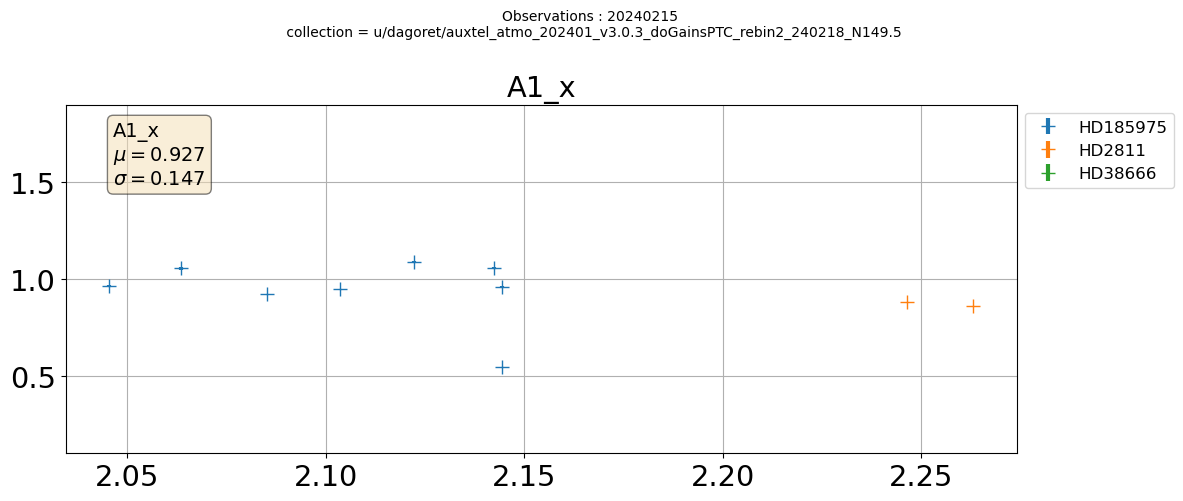

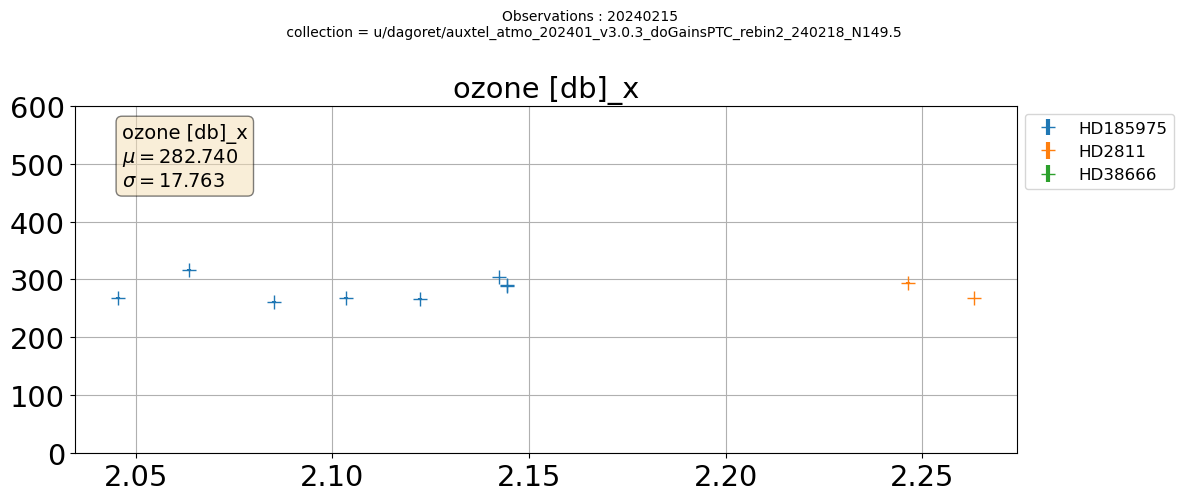

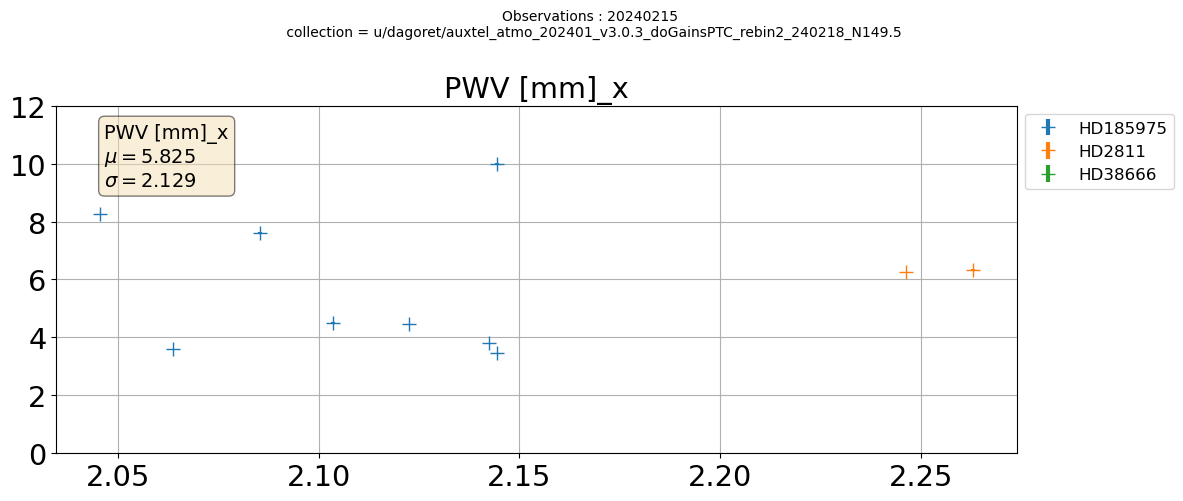

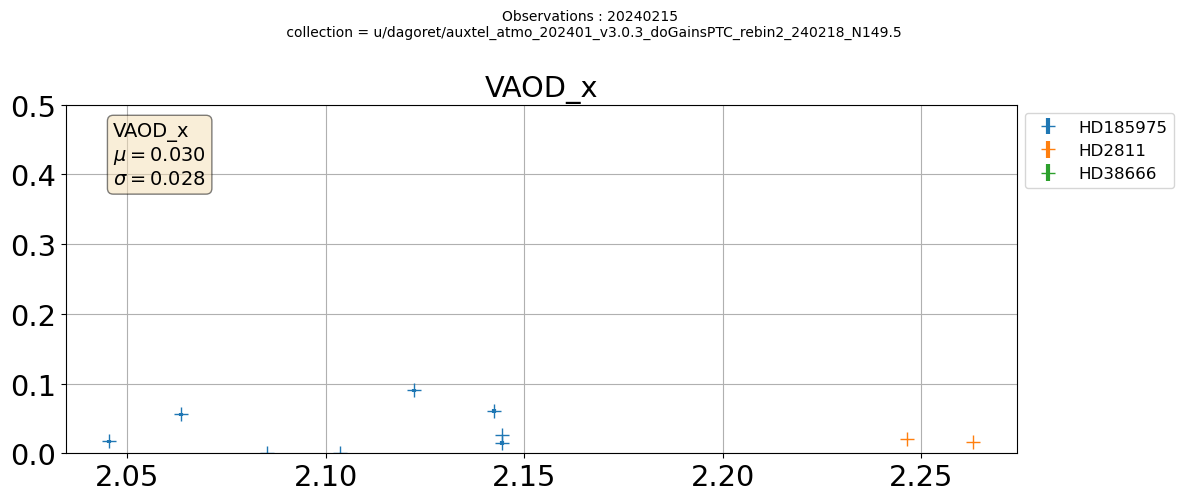

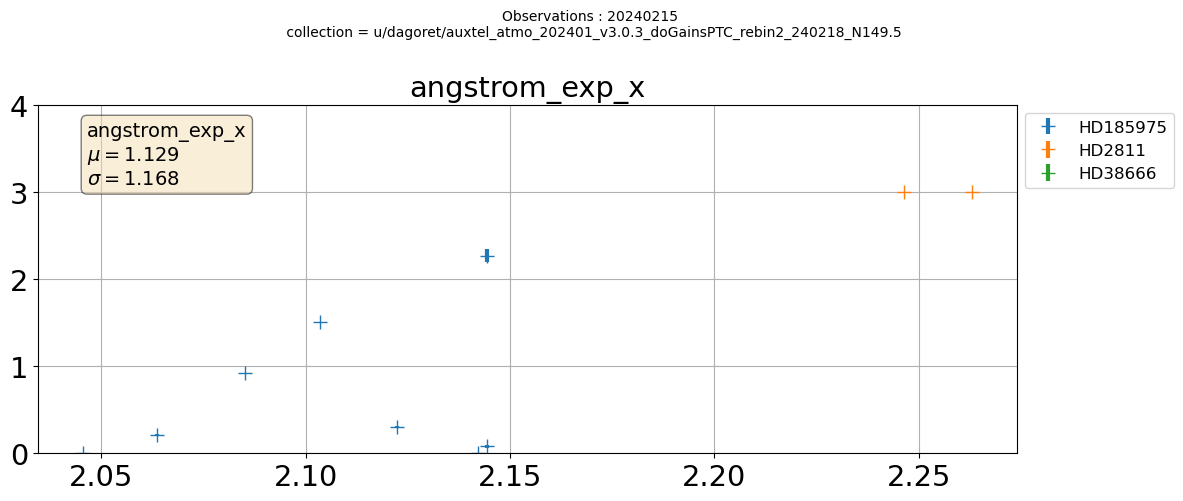

In [52]:
#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","angstrom_exp_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(12,5))

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))



    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=10,lw=3 ,label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3 )
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()


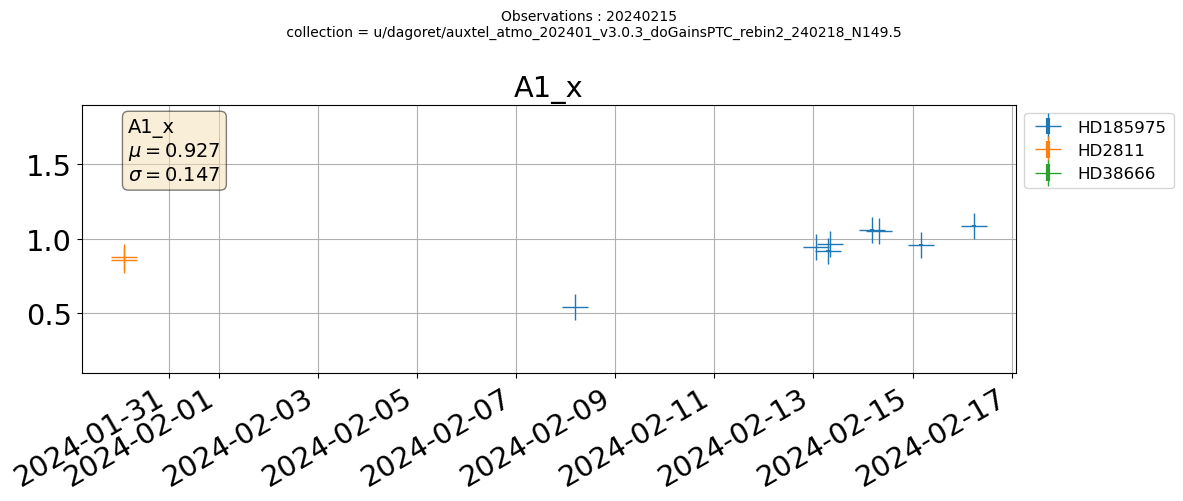

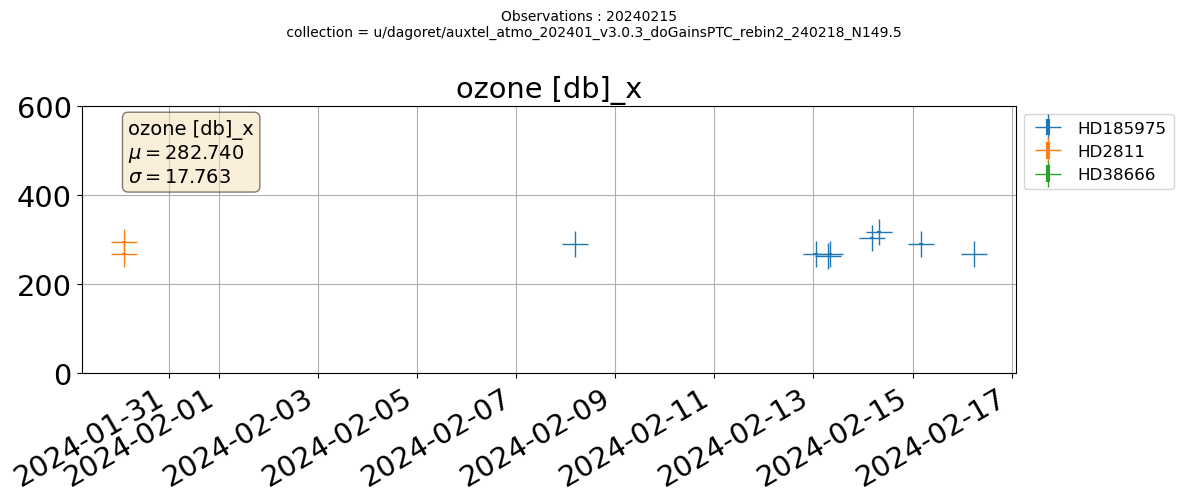

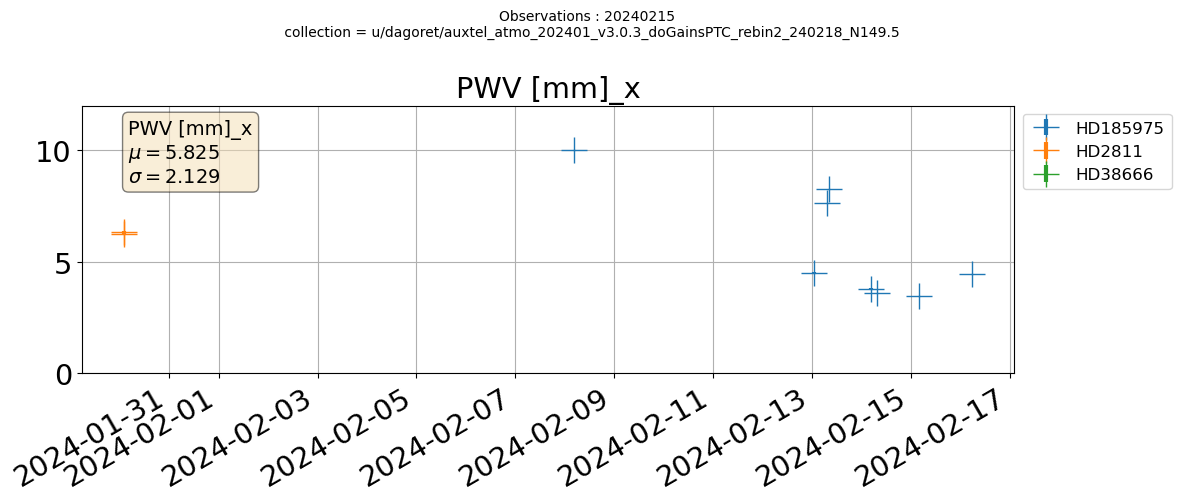

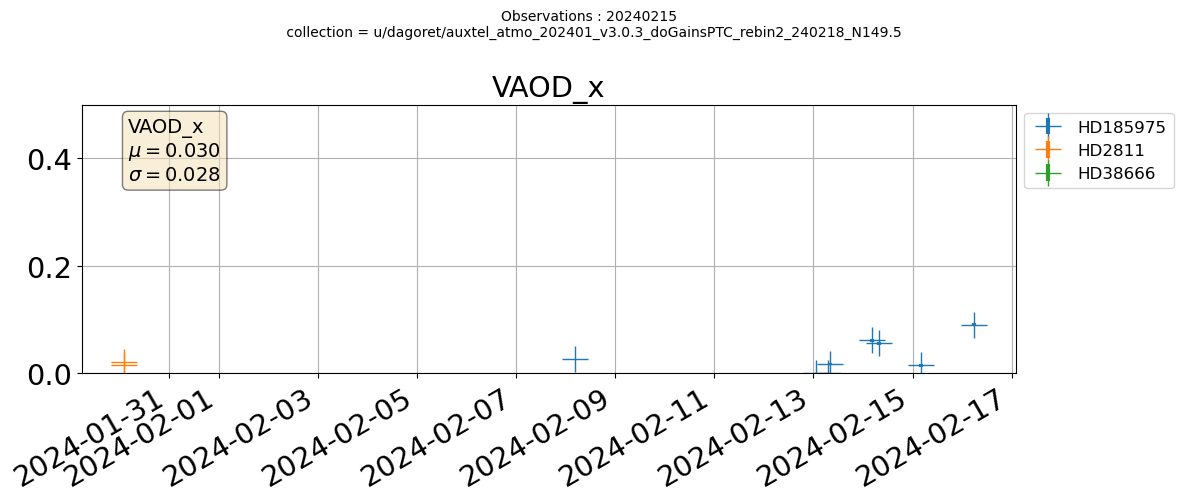

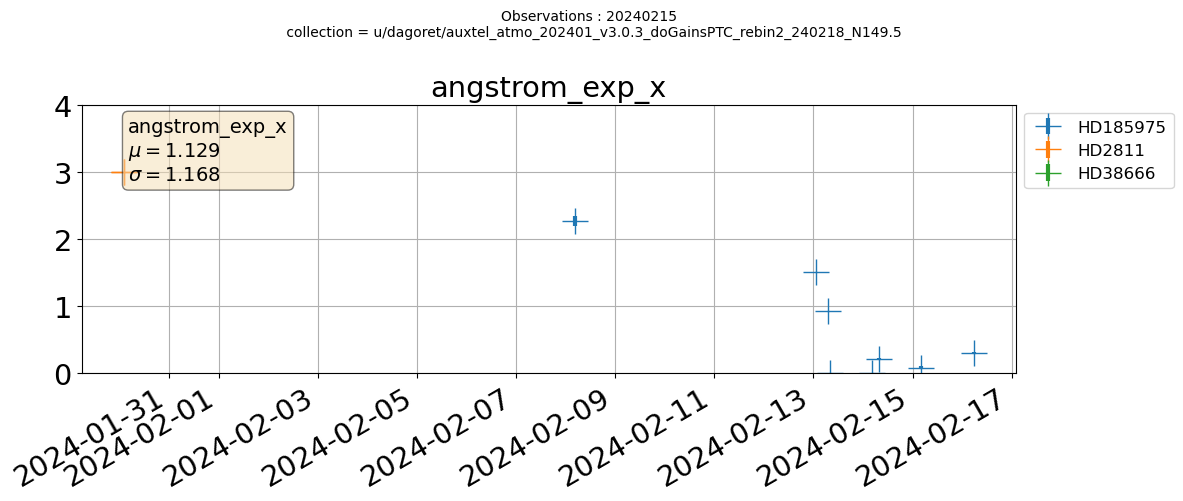

In [53]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","angstrom_exp_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(12,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

In [54]:
len(filtered)

75

In [55]:
print(filtered)

[False False False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False  True False False False False
 False False False  True False  True False False False False  True False
 False False False False False False False False  True False False False
 False  True False False False False False False False False False  True
 False False False]


In [56]:
df

id  BITPIX  NAXIS  NAXIS1  \
DATE-OBS                                                                    
2024-01-30 01:12:10.133003850+00:00  2024012900294     -64      2    1059   
2024-01-30 01:56:23.335993153+00:00  2024012900323     -64      2    1059   
2024-01-30 01:57:36.253501409+00:00  2024012900324     -64      2    1059   
2024-01-30 02:05:33.581508530+00:00  2024012900330     -64      2    1059   
2024-01-30 02:06:46.604509935+00:00  2024012900331     -64      2    1059   
...                                            ...     ...    ...     ...   
2024-02-16 05:34:16.662000343+00:00  2024021500245     -64      2    1059   
2024-02-16 05:35:29.760995833+00:00  2024021500246     -64      2    1059   
2024-02-16 05:43:19.319990387+00:00  2024021500252     -64      2    1059   
2024-02-16 06:40:42.363003734+00:00  2024021500293     -64      2    1059   
2024-02-16 06:41:55.449496028+00:00  2024021500294     -64      2    1059   

                                     NAXIS2  EXTEND    TARGET  REDSHIFT  \
DATE-OBS                                                                  
2024-01-30 01:12:10.133003850+00:00       3    True   HD38666  0.000364   
2024-01-30 01:56:23.335993153+00:00       3    True  HD185975 -0.000065   
2024-01-30 01:57:36.253501409+00:00       3    True  HD185975 -0.000065   
2024-01-30 02:05:33.581508530+00:00       3    True    HD2811  0.000000   
2024-01-30 02:06:46.604509935+00:00       3    True    HD2811  0.000000   
...                                     ...     ...       ...       ...   
2024-02-16 05:34:16.662000343+00:00       3    True  HD185975 -0.000065   
2024-02-16 05:35:29.760995833+00:00       3    True  HD185975 -0.000065   
2024-02-16 05:43:19.319990387+00:00       3    True   HD38666  0.000364   
2024-02-16 06:40:42.363003734+00:00       3    True  HD185975 -0.000065   
2024-02-16 06:41:55.449496028+00:00       3    True  HD185975 -0.000065   

                                       GRATING  ROTANGLE  ...  PWV [mm]_err_y  \
DATE-OBS                                                  ...                   
2024-01-30 01:12:10.133003850+00:00  holo4_003  0.189044  ...        0.662450   
2024-01-30 01:56:23.335993153+00:00  holo4_003  0.134970  ...        0.041638   
2024-01-30 01:57:36.253501409+00:00  holo4_003  0.153747  ...        0.043881   
2024-01-30 02:05:33.581508530+00:00  holo4_003  0.133953  ...        0.060414   
2024-01-30 02:06:46.604509935+00:00  holo4_003  0.124950  ...        0.080177   
...                                        ...       ...  ...             ...   
2024-02-16 05:34:16.662000343+00:00  holo4_003  0.131287  ...        0.047149   
2024-02-16 05:35:29.760995833+00:00  holo4_003  0.132888  ...        0.077907   
2024-02-16 05:43:19.319990387+00:00  holo4_003  0.153519  ...        0.155726   
2024-02-16 06:40:42.363003734+00:00  holo4_003  0.122426  ...        0.197321   
2024-02-16 06:41:55.449496028+00:00  holo4_003  0.126157  ...        0.038838   

                                     reso [pix]  reso [pix]_err  D_CCD [mm]_y  \
DATE-OBS                                                                        
2024-01-30 01:12:10.133003850+00:00    1.010570        0.419342    182.085360   
2024-01-30 01:56:23.335993153+00:00    1.616518        0.026414    187.806980   
2024-01-30 01:57:36.253501409+00:00    1.282444        0.102622    182.040419   
2024-01-30 02:05:33.581508530+00:00    1.024475        0.038779    187.818319   
2024-01-30 02:06:46.604509935+00:00    1.020508        0.035054    187.877022   
...                                         ...             ...           ...   
2024-02-16 05:34:16.662000343+00:00    1.269639        0.030381    188.231707   
2024-02-16 05:35:29.760995833+00:00    1.043724        0.046294    187.770978   
2024-02-16 05:43:19.319990387+00:00    1.050680        0.251730    187.998603   
2024-02-16 06:40:42.363003734+00:00    0.992964        0.060050    187.679878   
2024-02-16 06:41:55.449496028+00:00    3.299

0 20240129 2 2
>>> List of targets  ['HD2811']
>>> ID.     :  20240129 [2024012900330, 2024012900331]
>>> AIRMASS :  20240129 [2.24640079579726, 2.26304847010233]


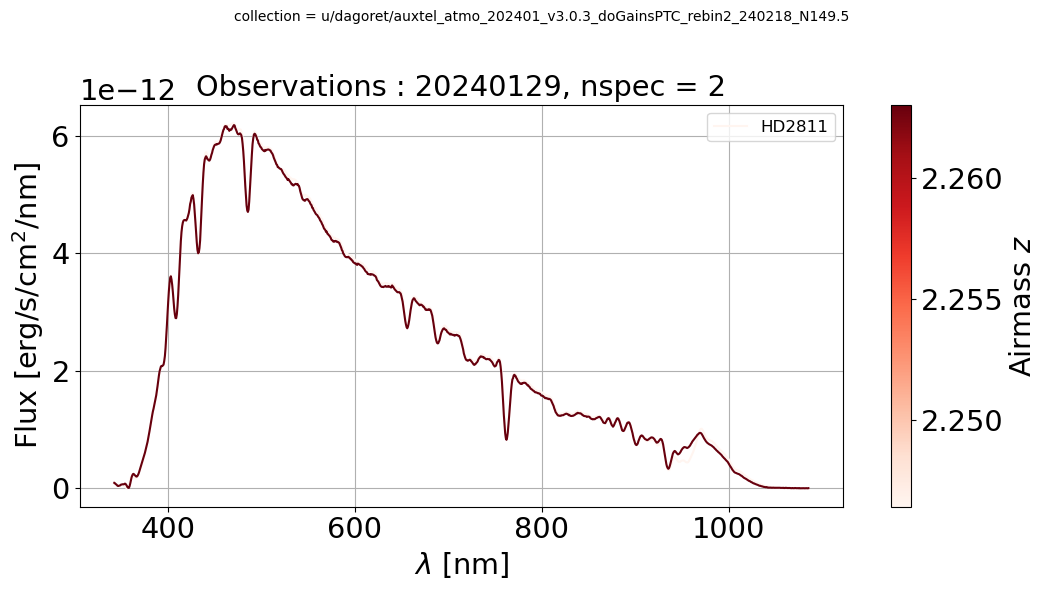

1 20240130 0 2
>>> List of targets  []
2 20240131 2 4
>>> List of targets  ['HD38666']
>>> ID.     :  20240131 [2024013100293, 2024013100294]
>>> AIRMASS :  20240131 [1.00268647575224, 1.00299102212379]


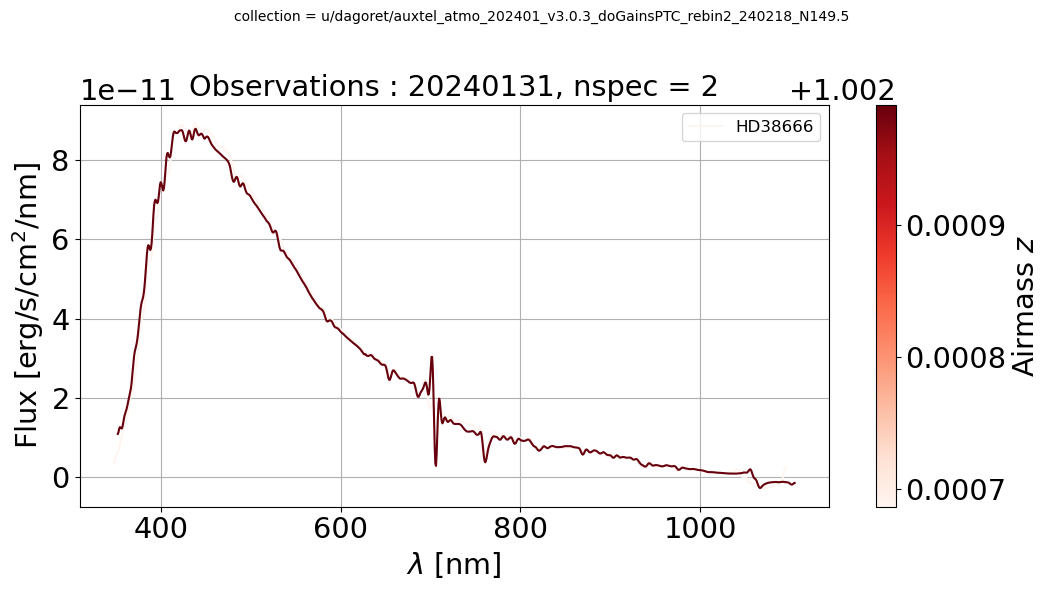

3 20240205 2 6
>>> List of targets  ['HD185975' 'HD2811']
>>> ID.     :  20240205 [2024020500034, 2024020500041]
>>> AIRMASS :  20240205 [2.08863387672932, 2.02591865462175]


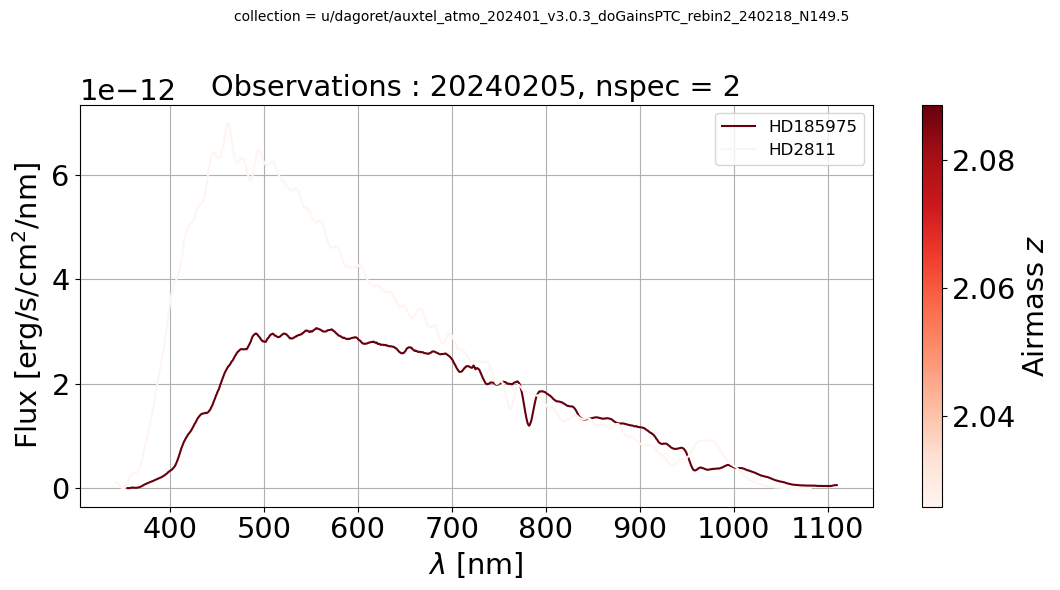

4 20240206 5 11
>>> List of targets  ['HD185975']
>>> ID.     :  20240206 [2024020600201, 2024020600202, 2024020600282, 2024020600283, 2024020600350]
>>> AIRMASS :  20240206 [2.14006382658196, 2.13983759061313, 2.10923875284958, 2.10866911575156, 2.05559801856528]


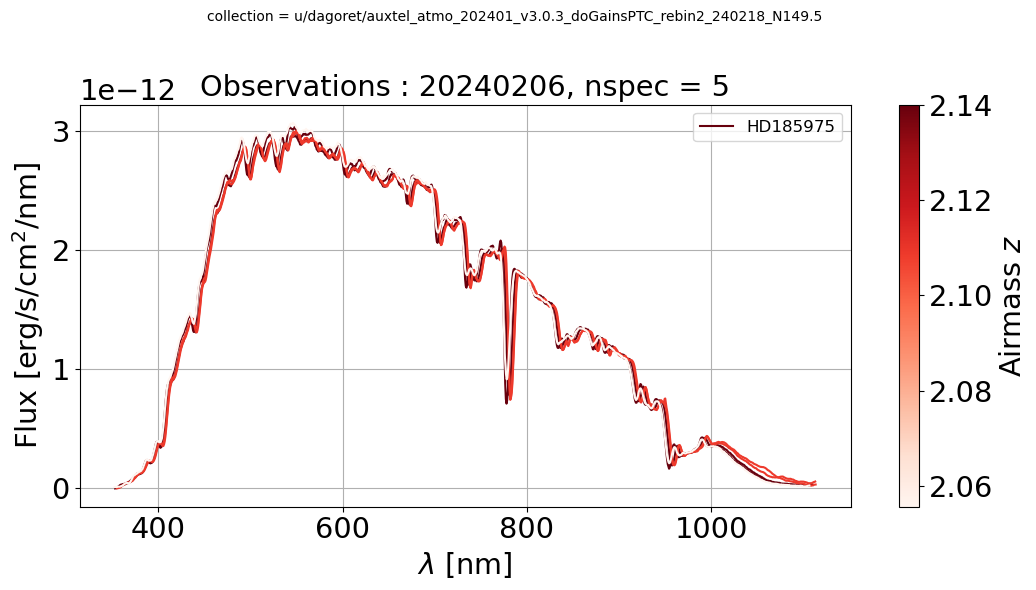

5 20240207 3 14
>>> List of targets  ['HD185975' 'HD38666']
>>> ID.     :  20240207 [2024020700405, 2024020700411, 2024020700412]
>>> AIRMASS :  20240207 [1.24278021617035, 2.14448264299641, 2.14443464271158]


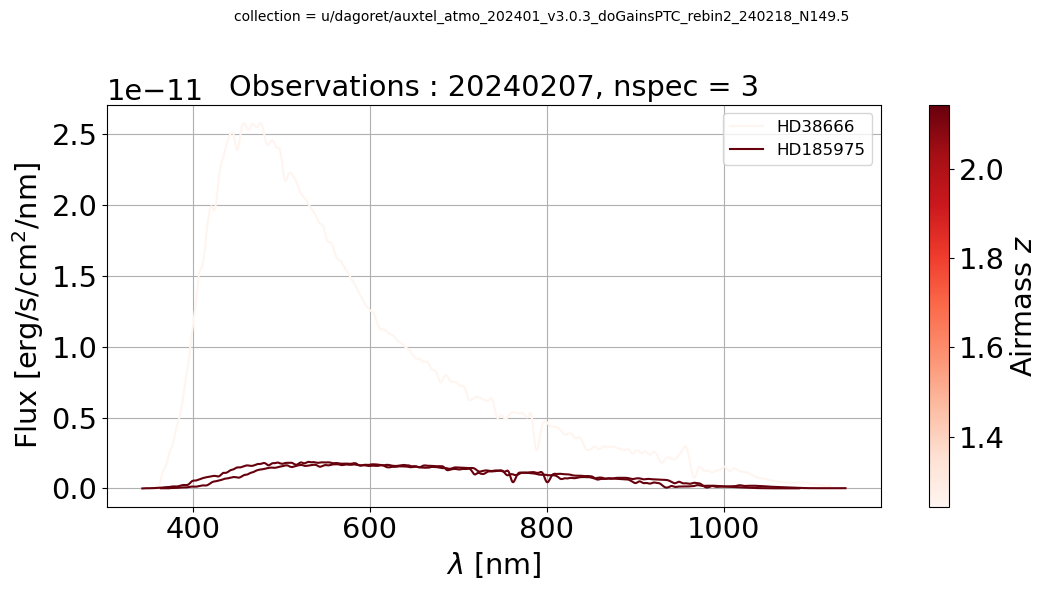

6 20240212 5 19
>>> List of targets  ['HD185975']
>>> ID.     :  20240212 [2024021200421, 2024021200526, 2024021200527, 2024021200593, 2024021200594]
>>> AIRMASS :  20240212 [2.10360324213764, 2.08597342399531, 2.08527901021243, 2.04624618434573, 2.04544278114646]


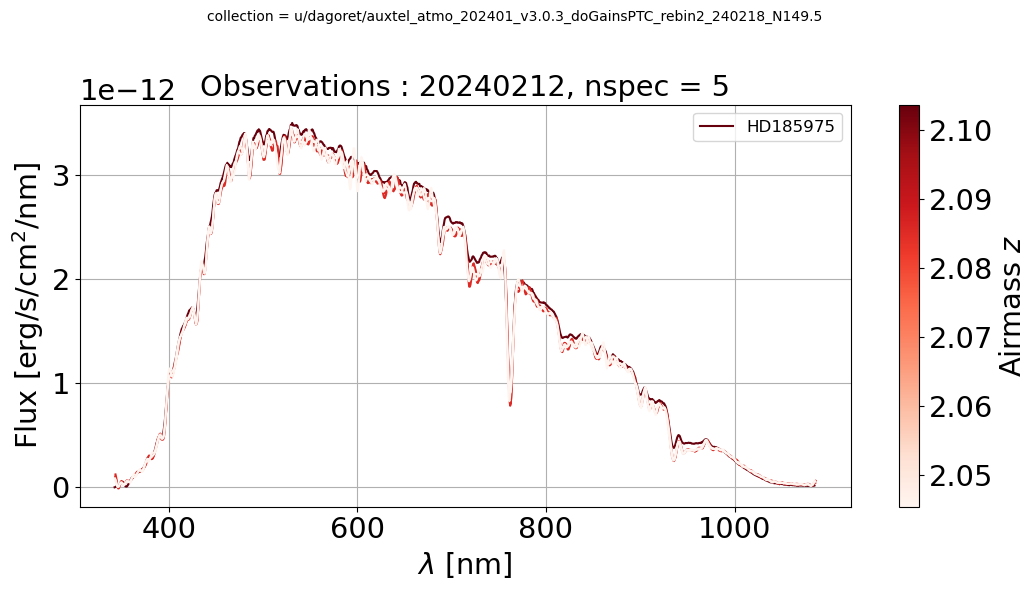

7 20240213 7 26
>>> List of targets  ['HD38666']
>>> ID.     :  20240213 [2024021300094, 2024021300108, 2024021300124, 2024021300151, 2024021300152, 2024021300182, 2024021300183]
>>> AIRMASS :  20240213 [1.30743272611362, 1.35761377221221, 1.50371940496777, 1.67093745320158, 1.67665053148208, 2.26521865924235, 2.27668485298832]


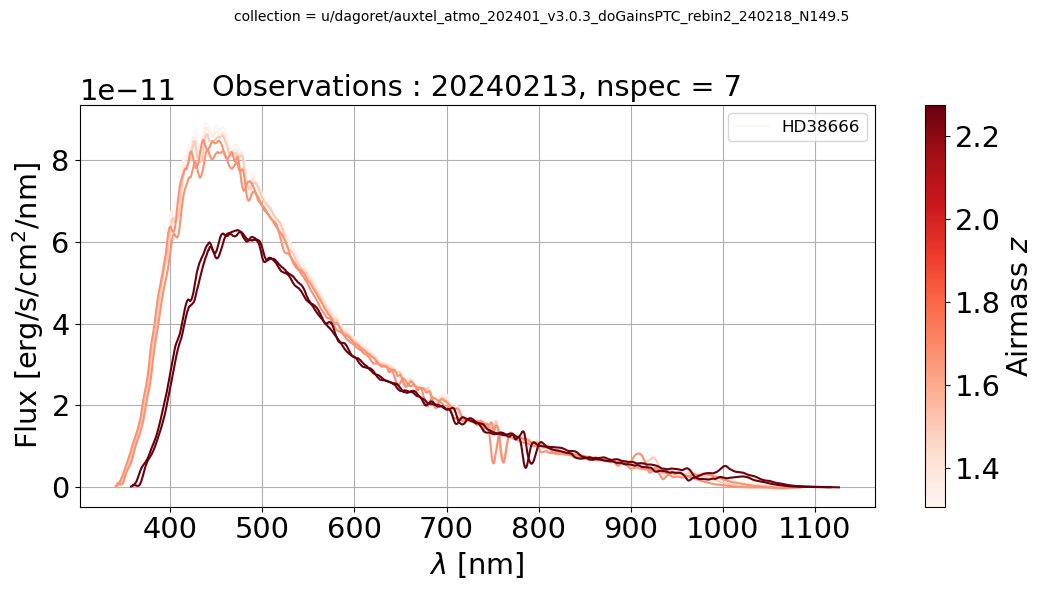

8 20240214 8 34
>>> List of targets  ['HD38666']
>>> ID.     :  20240214 [2024021400068, 2024021400076, 2024021400101, 2024021400102, 2024021400115, 2024021400130, 2024021400136, 2024021400137]
>>> AIRMASS :  20240214 [1.20509327449489, 1.22522104568144, 1.34225261342444, 1.34537236963363, 1.40803868249362, 1.55812360098439, 1.59391100732693, 1.59898717749373]


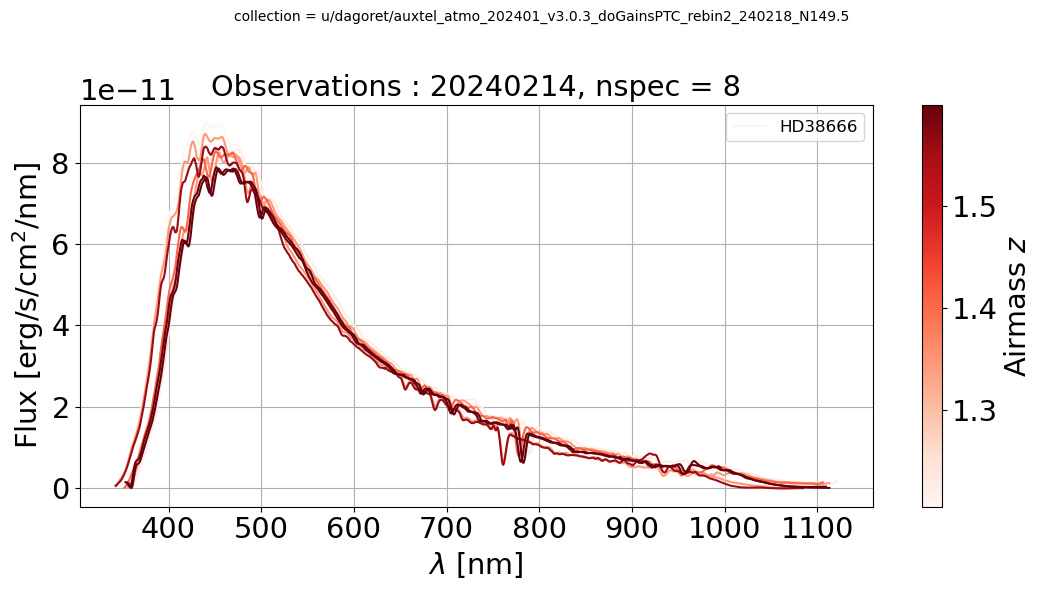

9 20240215 1 35
>>> List of targets  ['HD185975']
>>> ID.     :  20240215 [2024021500246]
>>> AIRMASS :  20240215 [2.1223544654735]
 
 /////// SKIPP 2024021500246 



In [57]:
count = 0
all_lists_of_targets = []
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]
    N = len(filtered_spectra)
    count += N
    print(idx,DATEOBS,len(filtered_spectra),count) 
    list_of_targets = np.unique([spec.target.label for spec in filtered_spectra])
    print(">>> List of targets ",list_of_targets)
    if len(list_of_targets) == 0:
        continue
    all_lists_of_targets.append(list_of_targets)
   
    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    
    if N>1:
        fig = plot_spectra(filtered_spectra, [spec.airmass for spec in filtered_spectra],collection=my_collection,dateobs=DATEOBS)
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")

## Make SED dictionnary

In [58]:
list_of_all_targets = np.unique(np.concatenate(all_lists_of_targets))

In [59]:
import getCalspec.getCalspec as gcal
all_calspecs = {}
for target_name in list_of_all_targets:
    c =  gcal.Calspec(target_name) 
    all_calspecs[target_name] = c.get_spectrum_numpy() 

(0.0, 5e-11)

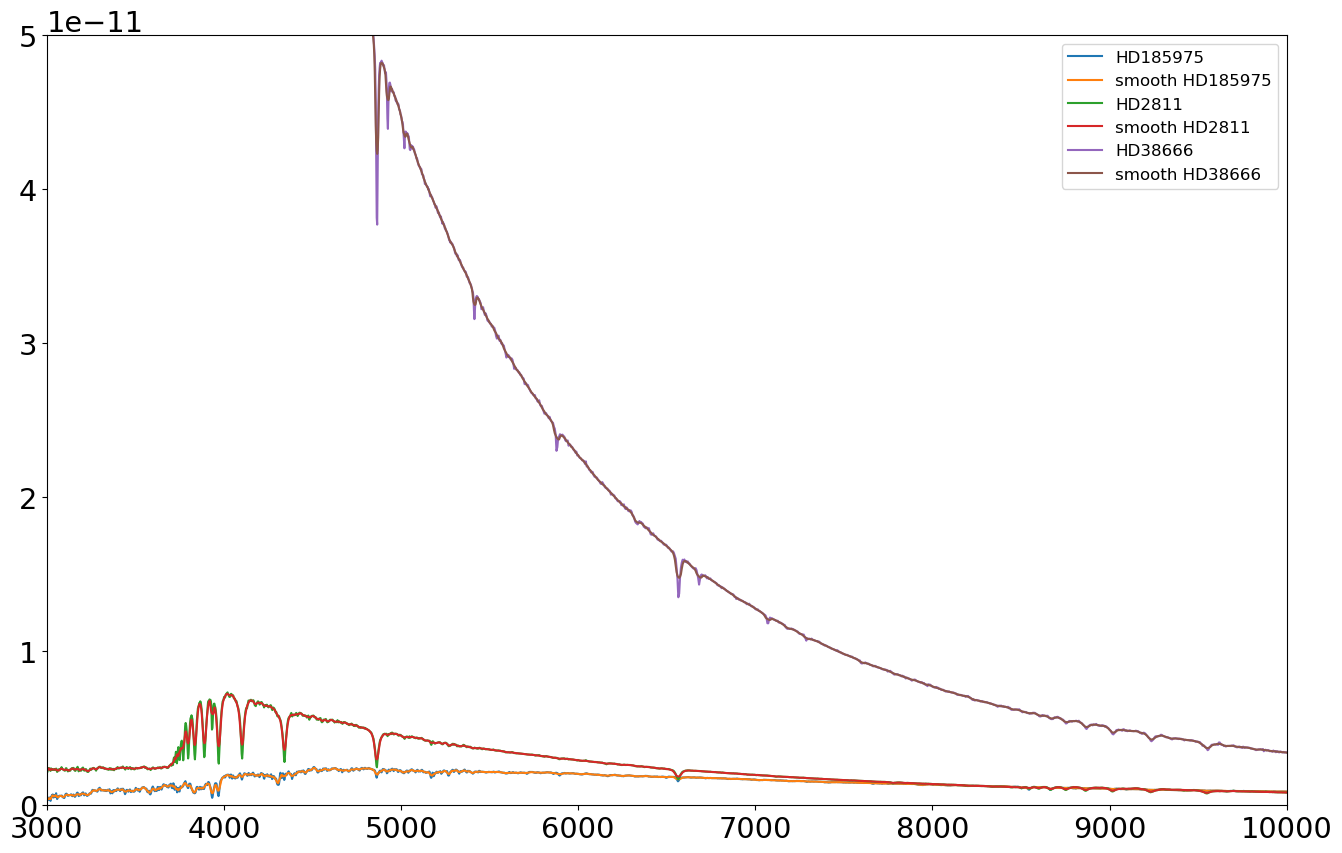

In [60]:
all_calspecs_sm = {}
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
span = 3
for target_name in list_of_all_targets:
    c_dict = all_calspecs[target_name]
    wls = c_dict["WAVELENGTH"].value
    sed = c_dict["FLUX"].value
    ax.plot(wls,sed,label=target_name)
    
    sedm = smooth_data_np_convolve(sed,span)
    c_dict_sm = {"WAVELENGTH":wls,"FLUX":sedm}
    all_calspecs_sm[target_name] = c_dict_sm
    ax.plot(wls,sedm,label="smooth " +target_name)
ax.legend()
ax.set_xlim(3000.,10000.)   
ax.set_ylim(0.,0.5e-10)

In [61]:
all_calspecs_sm

{'HD185975': {'WAVELENGTH': array([  1710.563477,   1711.934326,   1713.305298, ..., 318329.84375 ,
         318604.8125  , 318878.78125 ]),
  'FLUX': array([-6.52666268e-16, -1.59359481e-15, -3.34445197e-15, ...,
          2.63758665e-18,  2.19417811e-18,  1.75229412e-18])},
 'HD2811': {'WAVELENGTH': array([  1140.1373291,   1140.720947 ,   1141.304565 , ...,
         318350.       , 318625.       , 318899.       ]),
  'FLUX': array([7.23000400e-17, 7.14200061e-16, 4.56614347e-16, ...,
         1.48900024e-18, 1.23868600e-18, 9.89234438e-19])},
 'HD38666': {'WAVELENGTH': array([  1148.59997559,   1149.80004883,   1151.        , ...,
         318813.61132294, 318877.3844865 , 318941.15765005]),
  'FLUX': array([1.79769745e-09, 2.22715824e-09, 2.65523962e-09, ...,
         3.09722277e-18, 2.58078159e-18, 2.06455371e-18])}}

## Plot atmospheric transmissions

>>> ID.     :  20240129 [2024012900330, 2024012900331]
>>> AIRMASS :  20240129 [2.24640079579726, 2.26304847010233]


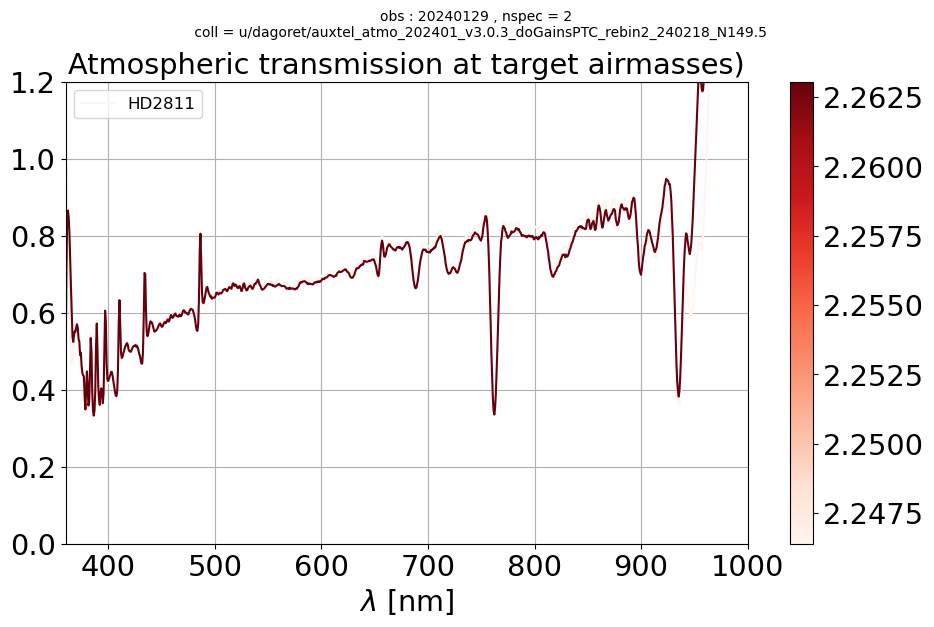

SKIP 1 20240130 []
>>> ID.     :  20240131 [2024013100293, 2024013100294]
>>> AIRMASS :  20240131 [1.00268647575224, 1.00299102212379]


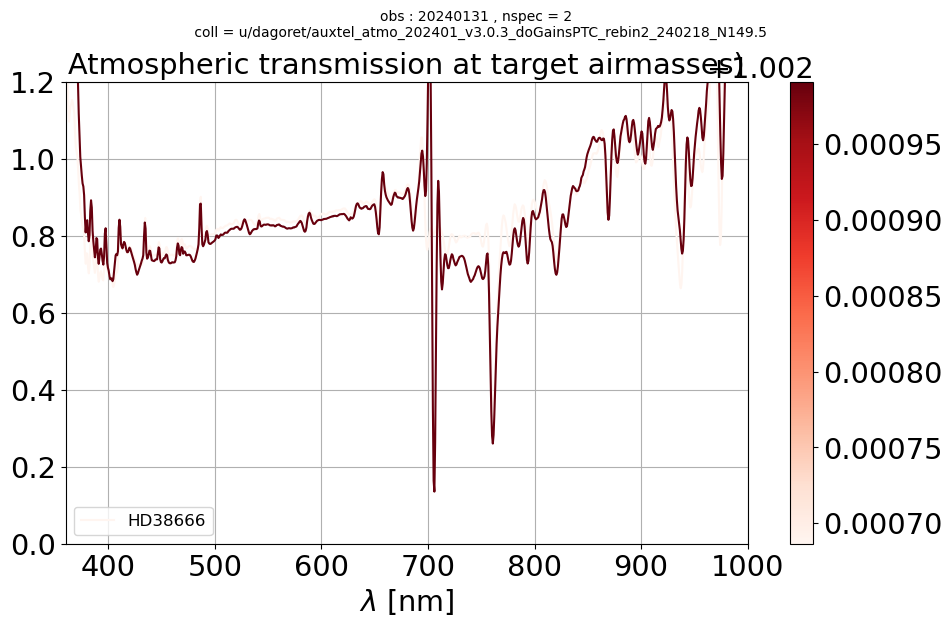

>>> ID.     :  20240205 [2024020500034, 2024020500041]
>>> AIRMASS :  20240205 [2.08863387672932, 2.02591865462175]


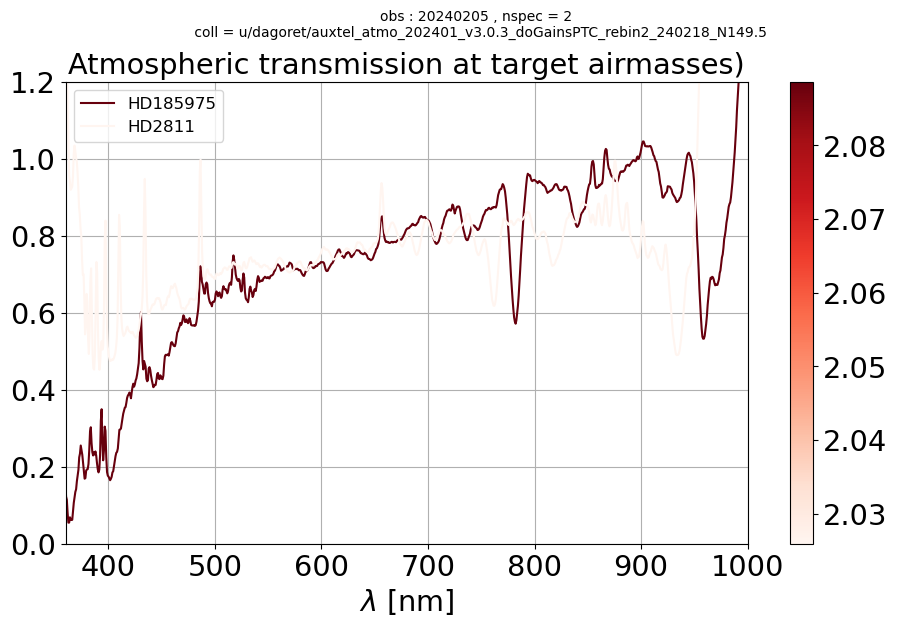

>>> ID.     :  20240206 [2024020600201, 2024020600202, 2024020600282, 2024020600283, 2024020600350]
>>> AIRMASS :  20240206 [2.14006382658196, 2.13983759061313, 2.10923875284958, 2.10866911575156, 2.05559801856528]


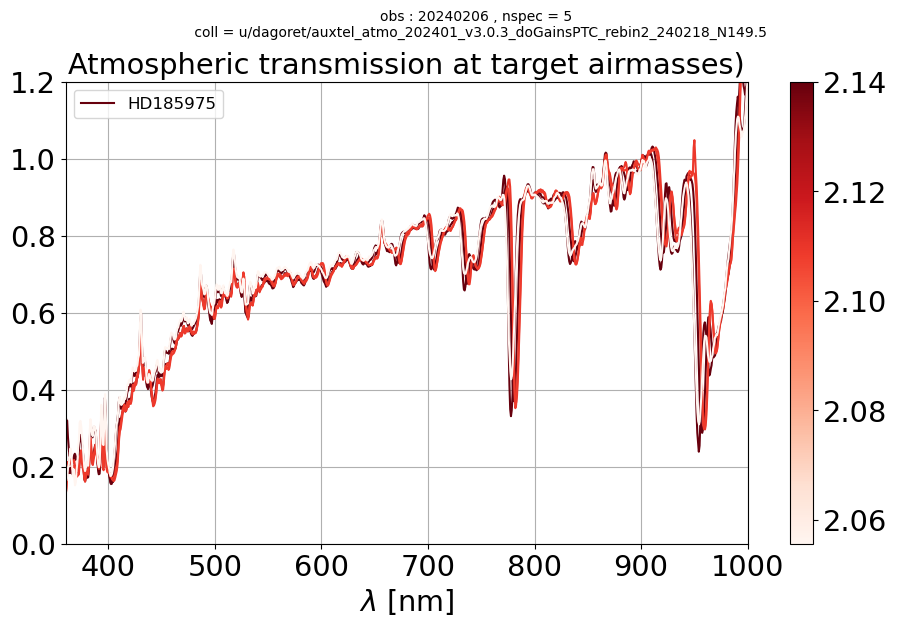

>>> ID.     :  20240207 [2024020700405, 2024020700411, 2024020700412]
>>> AIRMASS :  20240207 [1.24278021617035, 2.14448264299641, 2.14443464271158]


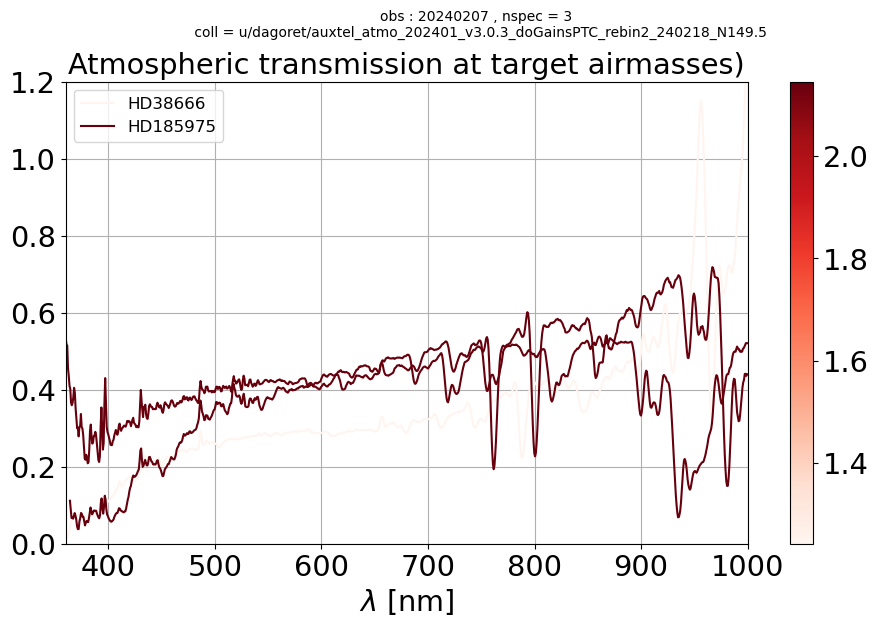

>>> ID.     :  20240212 [2024021200421, 2024021200526, 2024021200527, 2024021200593, 2024021200594]
>>> AIRMASS :  20240212 [2.10360324213764, 2.08597342399531, 2.08527901021243, 2.04624618434573, 2.04544278114646]


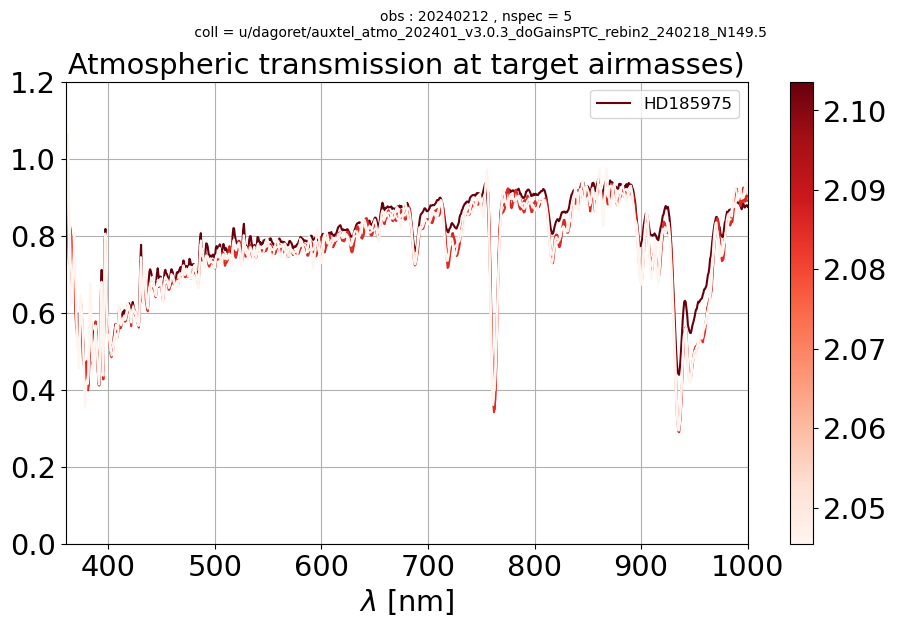

>>> ID.     :  20240213 [2024021300094, 2024021300108, 2024021300124, 2024021300151, 2024021300152, 2024021300182, 2024021300183]
>>> AIRMASS :  20240213 [1.30743272611362, 1.35761377221221, 1.50371940496777, 1.67093745320158, 1.67665053148208, 2.26521865924235, 2.27668485298832]


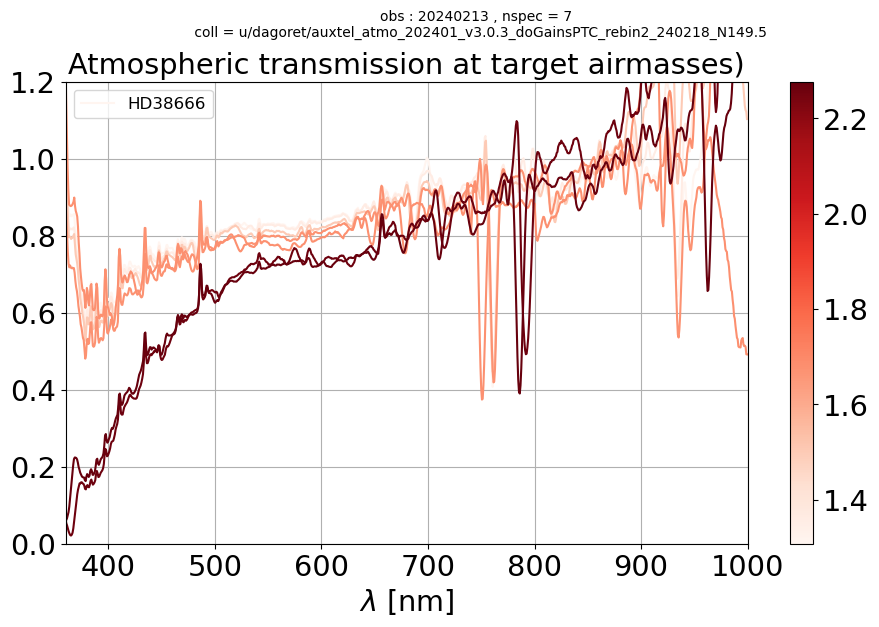

>>> ID.     :  20240214 [2024021400068, 2024021400076, 2024021400101, 2024021400102, 2024021400115, 2024021400130, 2024021400136, 2024021400137]
>>> AIRMASS :  20240214 [1.20509327449489, 1.22522104568144, 1.34225261342444, 1.34537236963363, 1.40803868249362, 1.55812360098439, 1.59391100732693, 1.59898717749373]


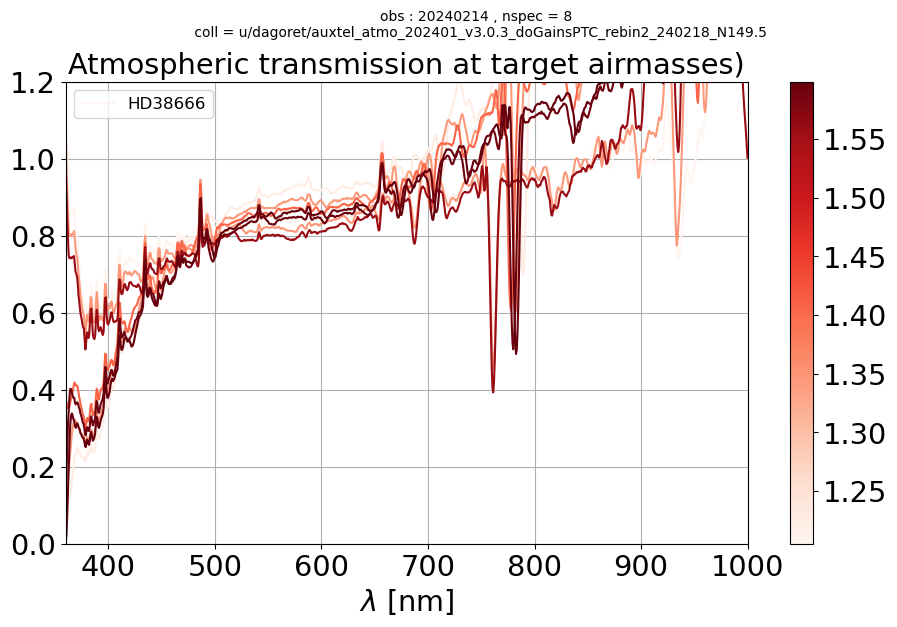

>>> ID.     :  20240215 [2024021500246]
>>> AIRMASS :  20240215 [2.1223544654735]
 
 /////// SKIPP 2024021500246 



In [62]:
count = 0
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    
    N = len(selected_ids)

    if N ==0:
        print("SKIP",idx,DATEOBS,selected_ids)
        continue
        
    cut = (df.id == selected_ids[0])

    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    
    if N > 1:
        plot_atmtransmission(filtered_spectra, [spec.airmass for spec in filtered_spectra],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS)
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")


## Plot atmospheric transmissions for airmass = 1

$$
T(z_{pred}) = \frac{ \left( T(z_{meas}) \right)^\left( \frac{z_{pred}}{z_{meas}}\right)}{(T^{grey}_{z_{meas}})^{z_{pred}}}
$$

>>> ID.     :  20240129 [2024012900330, 2024012900331]
>>> AIRMASS :  20240129 [2.24640079579726, 2.26304847010233]


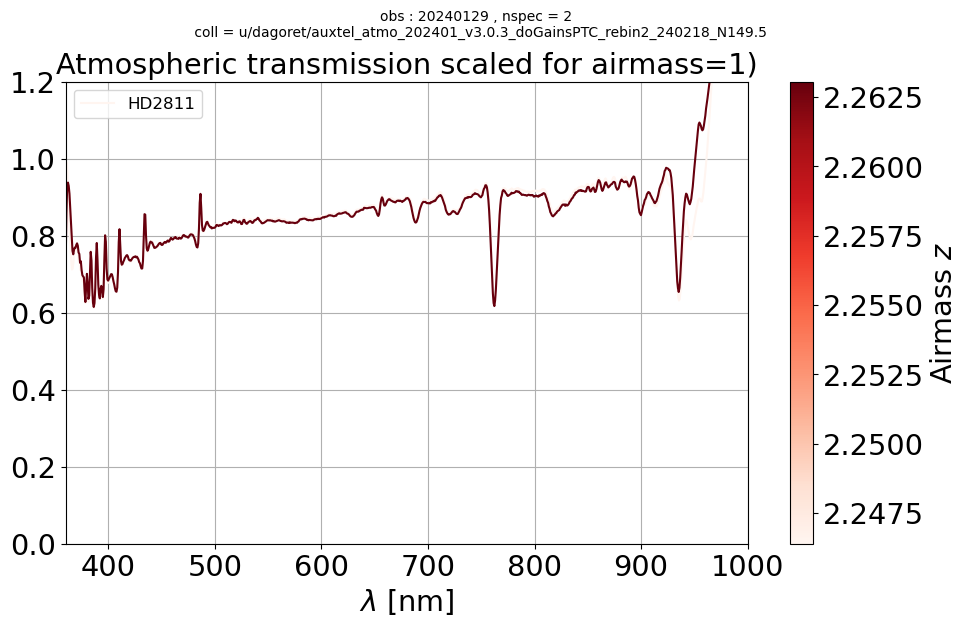

SKIP 1 20240130 []
>>> ID.     :  20240131 [2024013100293, 2024013100294]
>>> AIRMASS :  20240131 [1.00268647575224, 1.00299102212379]


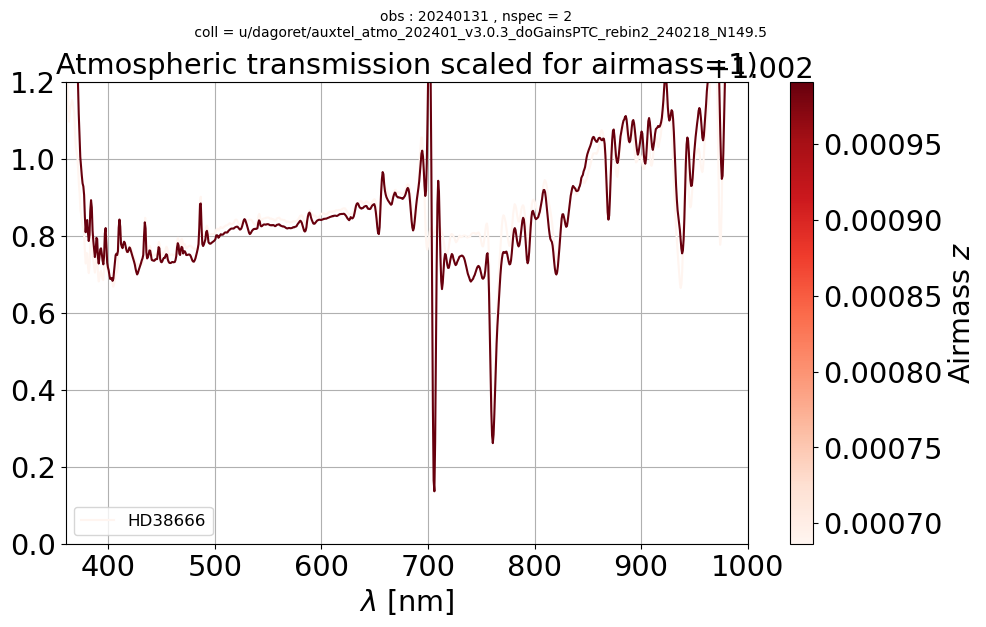

>>> ID.     :  20240205 [2024020500034, 2024020500041]
>>> AIRMASS :  20240205 [2.08863387672932, 2.02591865462175]


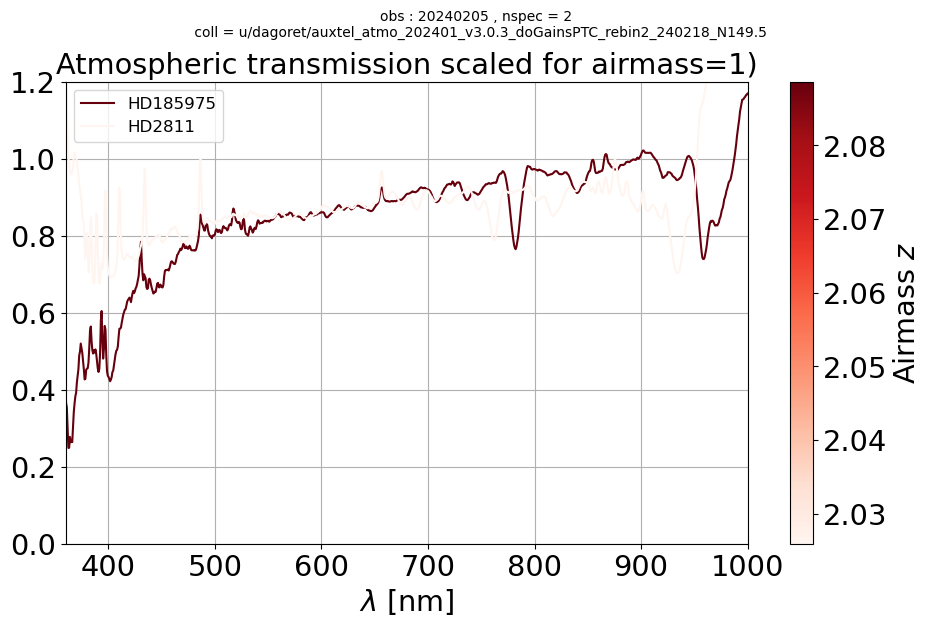

>>> ID.     :  20240206 [2024020600201, 2024020600202, 2024020600282, 2024020600283, 2024020600350]
>>> AIRMASS :  20240206 [2.14006382658196, 2.13983759061313, 2.10923875284958, 2.10866911575156, 2.05559801856528]


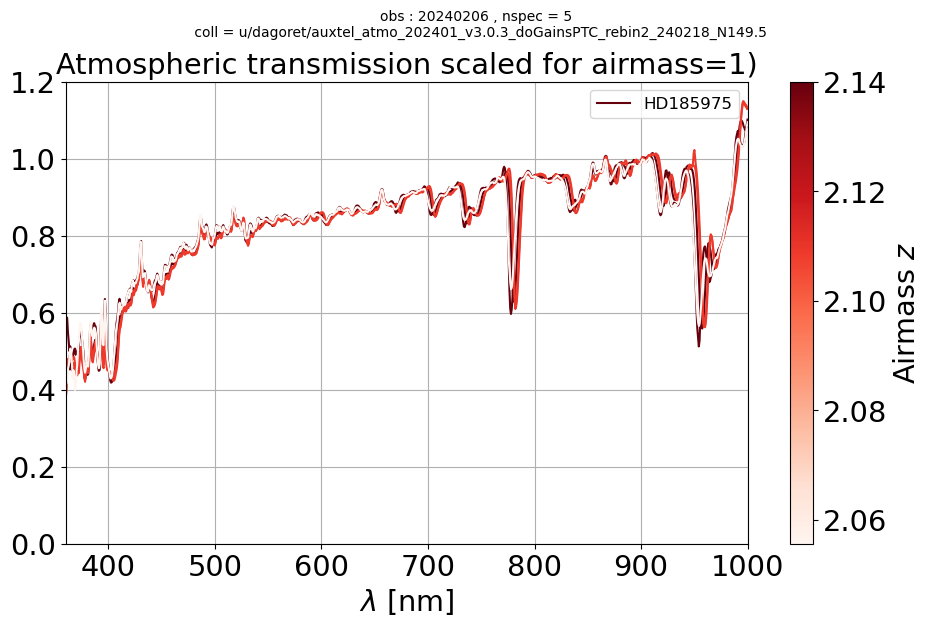

>>> ID.     :  20240207 [2024020700405, 2024020700411, 2024020700412]
>>> AIRMASS :  20240207 [1.24278021617035, 2.14448264299641, 2.14443464271158]


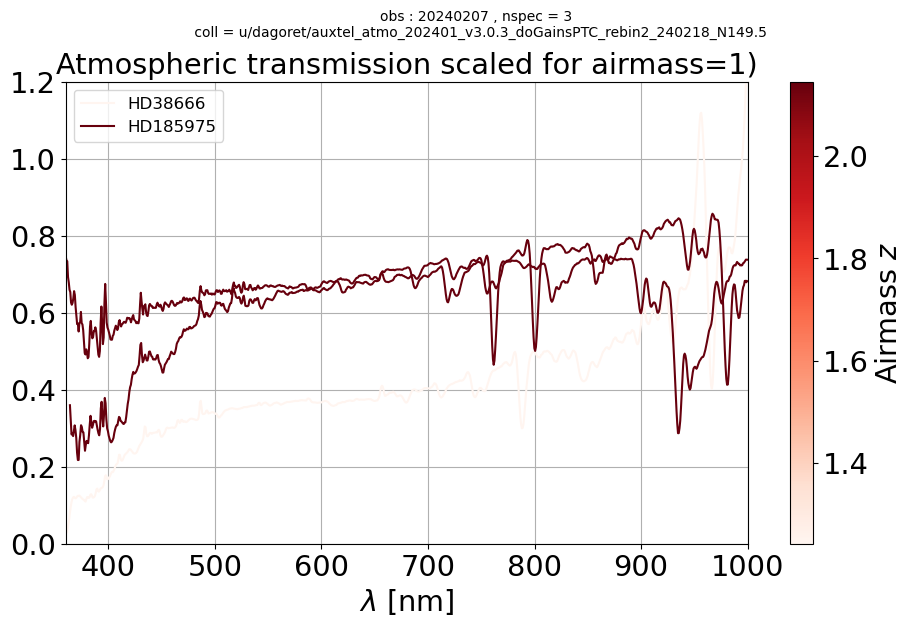

>>> ID.     :  20240212 [2024021200421, 2024021200526, 2024021200527, 2024021200593, 2024021200594]
>>> AIRMASS :  20240212 [2.10360324213764, 2.08597342399531, 2.08527901021243, 2.04624618434573, 2.04544278114646]


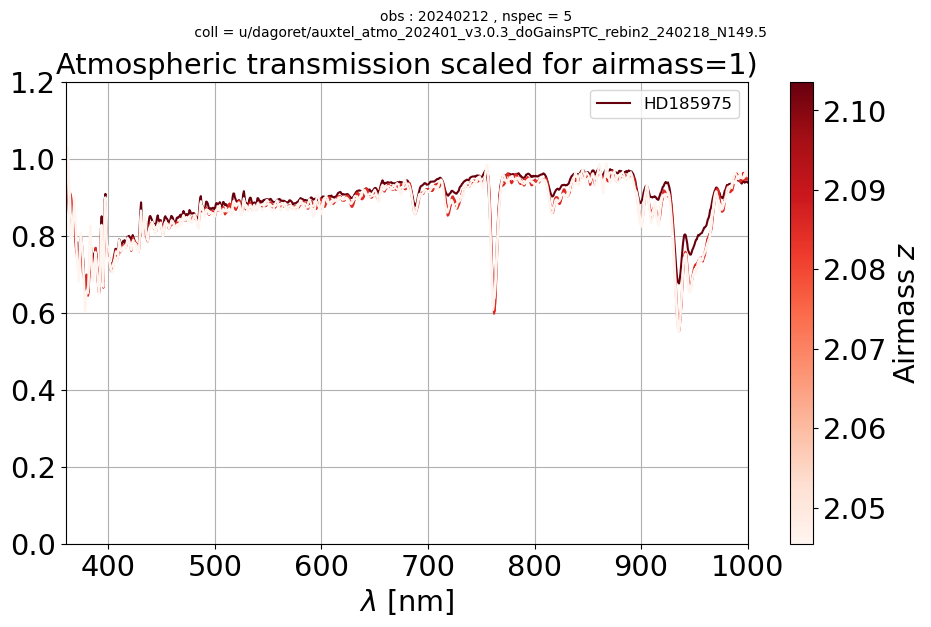

>>> ID.     :  20240213 [2024021300094, 2024021300108, 2024021300124, 2024021300151, 2024021300152, 2024021300182, 2024021300183]
>>> AIRMASS :  20240213 [1.30743272611362, 1.35761377221221, 1.50371940496777, 1.67093745320158, 1.67665053148208, 2.26521865924235, 2.27668485298832]


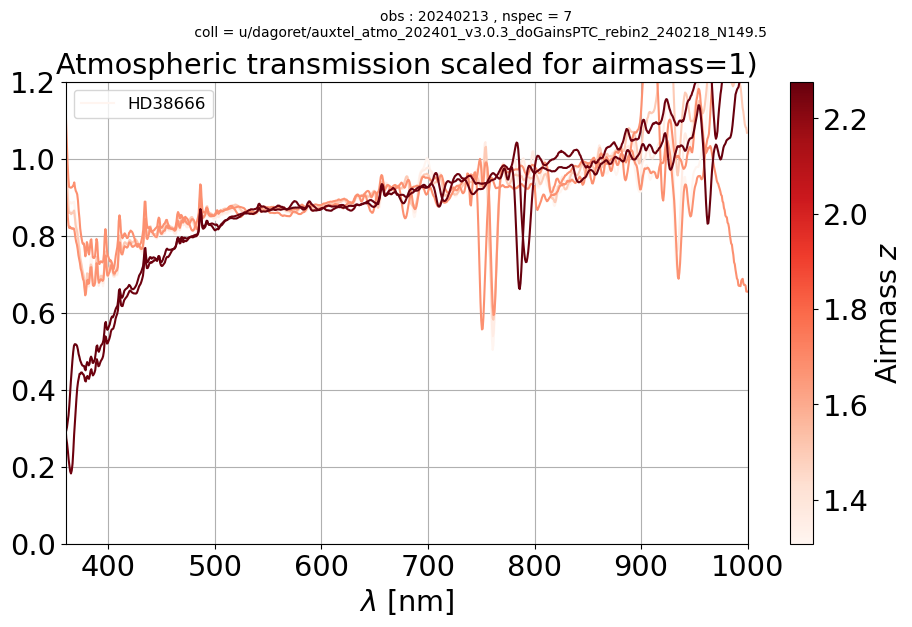

>>> ID.     :  20240214 [2024021400068, 2024021400076, 2024021400101, 2024021400102, 2024021400115, 2024021400130, 2024021400136, 2024021400137]
>>> AIRMASS :  20240214 [1.20509327449489, 1.22522104568144, 1.34225261342444, 1.34537236963363, 1.40803868249362, 1.55812360098439, 1.59391100732693, 1.59898717749373]


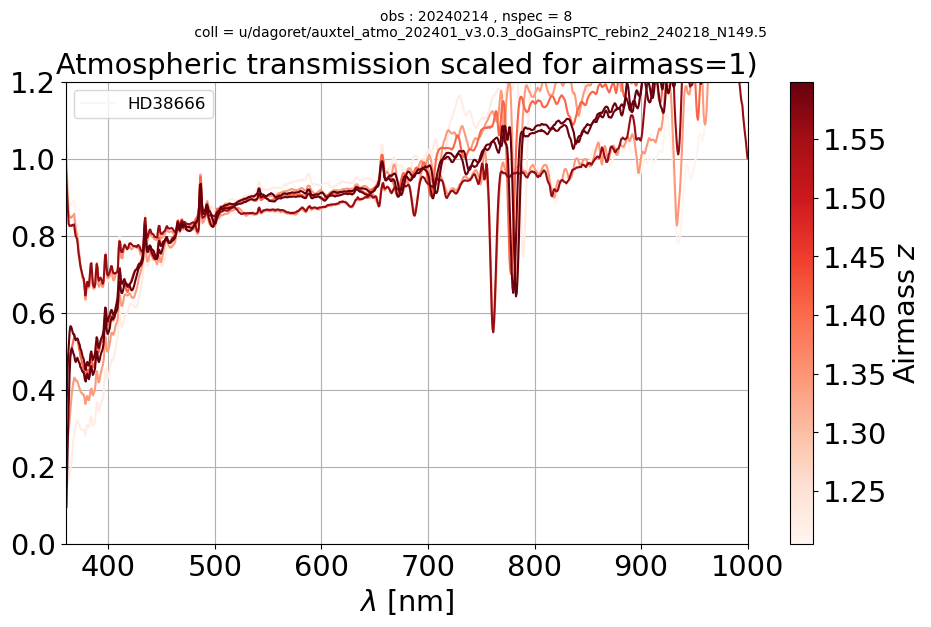

>>> ID.     :  20240215 [2024021500246]
>>> AIRMASS :  20240215 [2.1223544654735]
 
 /////// SKIPP 2024021500246 



In [63]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]

    N = len(selected_ids)

    if N ==0:
        print("SKIP",idx,DATEOBS,selected_ids)
        continue
    
    cut = (df.id == selected_ids[0])
   
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    

    if N > 1:
        plot_atmtransmission_zcorr(filtered_spectra, [ spec.airmass for spec in filtered_spectra ],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS )
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")    

## Show with simulation

In [64]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]
    
    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]

    N = len(selected_ids)

    if N ==0:
        print("SKIP",idx,DATEOBS,selected_ids)
        continue
        
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])

    break
    

>>> ID.     :  20240129 [2024012900330, 2024012900331]
>>> AIRMASS :  20240129 [2.24640079579726, 2.26304847010233]


In [65]:
df_good = df_sel[df_sel.filtered].drop(["id","filtered"],axis=1)
m_A1 , m_ozone, m_PWV, m_VAOD = df_good.mean().values
print(m_A1 , m_ozone, m_PWV, m_VAOD)

0.8710186953997314 281.29755329976575 6.298323979167375 0.01780571949057626


In [66]:
for spec in filtered_spectra:
    row = df_sel[df_sel.id == spec.dataId]
    (s_id, s_target, s_A1, s_ozone, s_PWV, s_VAOD, s_flag) = row.values[0]
    if s_flag:
        pwv=s_PWV
        oz=s_ozone
        vaod=s_VAOD
        grey=s_A1
    else:
        pwv=m_PWV
        oz=m_ozone
        vaod=m_VAOD
        grey=m_A1

>>> ID.     :  20240129 [2024012900330, 2024012900331]
>>> AIRMASS :  20240129 [2.24640079579726, 2.26304847010233]
 mean atm parameters 0.8710186953997314 281.29755329976575 6.298323979167375 0.01780571949057626
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


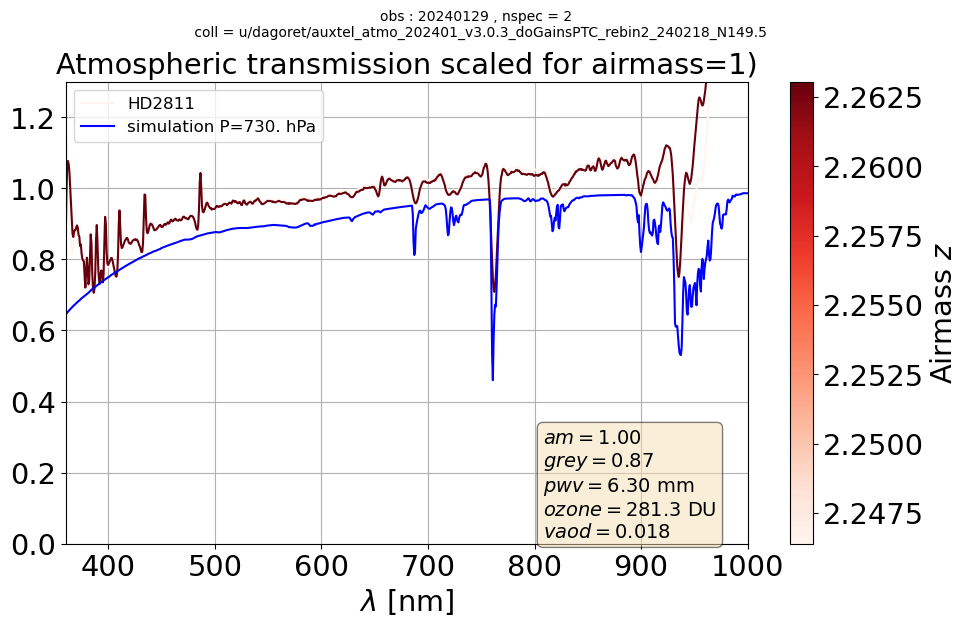

SKIP 1 20240130 []
>>> ID.     :  20240131 [2024013100293, 2024013100294]
>>> AIRMASS :  20240131 [1.00268647575224, 1.00299102212379]
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
 
 >>>>>>>> EXCEPTION SKIPP 2024013100293 - 2024013100294 

>>> ID.     :  20240205 [2024020500034, 2024020500041]
>>> AIRMASS :  20240205 [2.08863387672932, 2.02591865462175]
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
 
 >>>>>>>> EXCEPTION SKIPP 2024020500034 - 2024020500041 

>>> ID.     :  20240206 [2024020600201, 2024020600202, 2024020600282, 2024020600283, 2024020600350]
>>> AIRMASS :  20240206 [2.14006382658196, 2.13983759061313, 2.10923875284958, 2.10866911575156, 2.05559801856528]
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
 
 >>>>>>>> EXCEPTION SKIPP 2024020600201 - 2024020600350 

>>> ID.     :  20240207 [2024020700405, 20

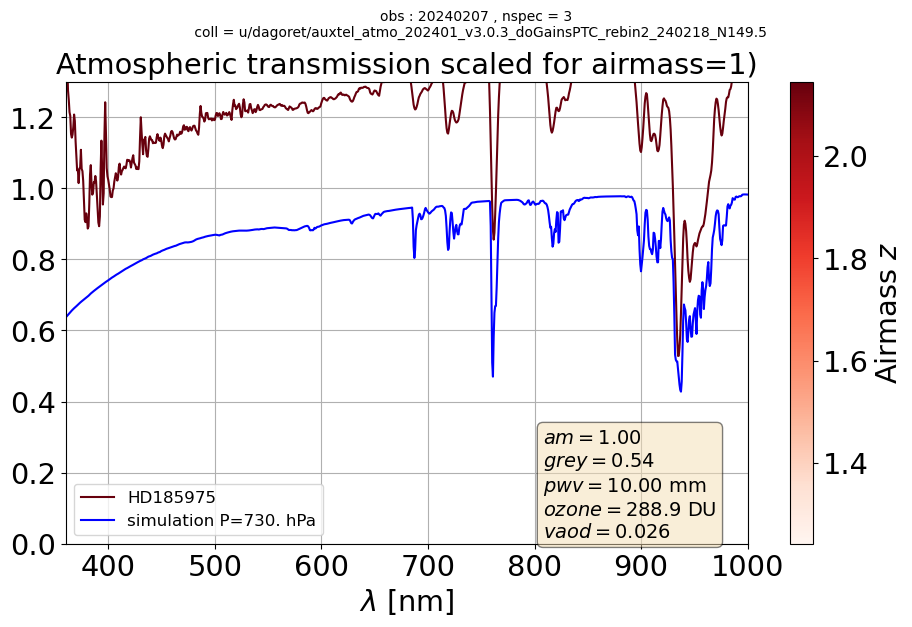

>>> ID.     :  20240212 [2024021200421, 2024021200526, 2024021200527, 2024021200593, 2024021200594]
>>> AIRMASS :  20240212 [2.10360324213764, 2.08597342399531, 2.08527901021243, 2.04624618434573, 2.04544278114646]
 mean atm parameters 0.9459249118868985 268.2371225252475 7.61676493982097 0.0
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


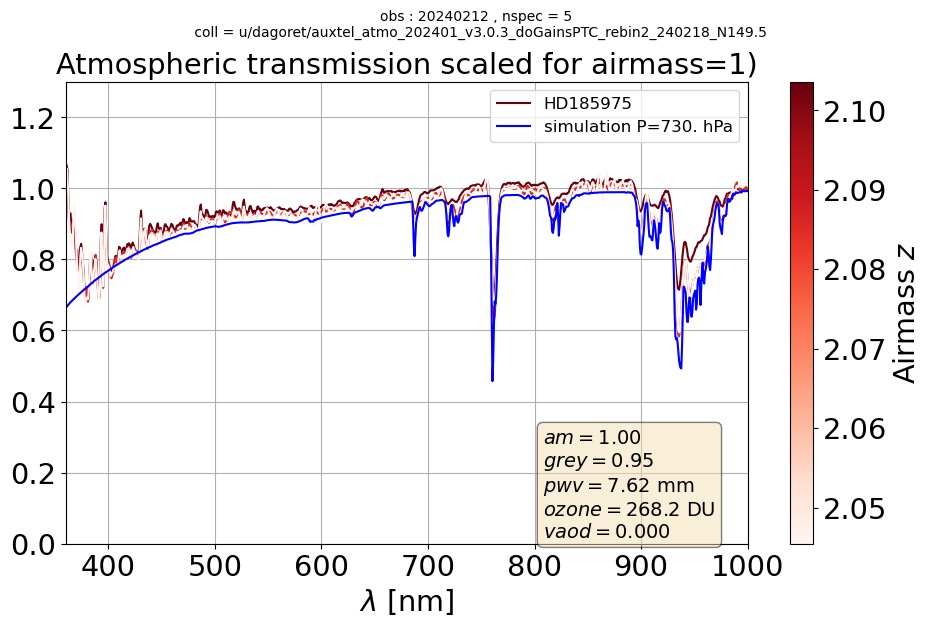

>>> ID.     :  20240213 [2024021300094, 2024021300108, 2024021300124, 2024021300151, 2024021300152, 2024021300182, 2024021300183]
>>> AIRMASS :  20240213 [1.30743272611362, 1.35761377221221, 1.50371940496777, 1.67093745320158, 1.67665053148208, 2.26521865924235, 2.27668485298832]
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
 
 >>>>>>>> EXCEPTION SKIPP 2024021300094 - 2024021300183 

>>> ID.     :  20240214 [2024021400068, 2024021400076, 2024021400101, 2024021400102, 2024021400115, 2024021400130, 2024021400136, 2024021400137]
>>> AIRMASS :  20240214 [1.20509327449489, 1.22522104568144, 1.34225261342444, 1.34537236963363, 1.40803868249362, 1.55812360098439, 1.59391100732693, 1.59898717749373]
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
 
 >>>>>>>> EXCEPTION SKIPP 2024021400068 - 2024021400137 

>>> ID.     :  20240215 [2024021500246]
>>> AIRMASS :  20240215 [2.1223544654

In [67]:
allall_meas_atmtransmissions_z1 = []
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]
    
    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]

    N = len(selected_ids)

    if N ==0:
        print("SKIP",idx,DATEOBS,selected_ids)
        continue
        
    cut = (df.id == selected_ids[0])
    
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    
    if N> 1:
    #plot_atmtransmission_zcorr(filtered_spectra, [ spec.airmass for spec in spectra_filtered ],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS )
        try:
            all_meas_atmtransmissions_z1 = plot_atmtransmission_zcorr_antatmsim(filtered_spectra, [ spec.airmass for spec in filtered_spectra ],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS,df_atm = df_sel)
            allall_meas_atmtransmissions_z1.append(all_meas_atmtransmissions_z1)
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)          # __str__ allows args to be printed directly,
                                 # but may be overridden in exception subclasses
            id0 = filtered_spectra[0].dataId
            id1 = filtered_spectra[-1].dataId
            print(f" \n >>>>>>>> EXCEPTION SKIPP {id0} - {id1} \n")
            allall_meas_atmtransmissions_z1.append([])
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")
        allall_meas_atmtransmissions_z1.append([])
    

>>> ID.     :  20240129 [2024012900330, 2024012900331]
>>> AIRMASS :  20240129 [2.24640079579726, 2.26304847010233]
 mean parameters 0.8710186953997314 281.29755329976575 6.298323979167375 0.01780571949057626
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


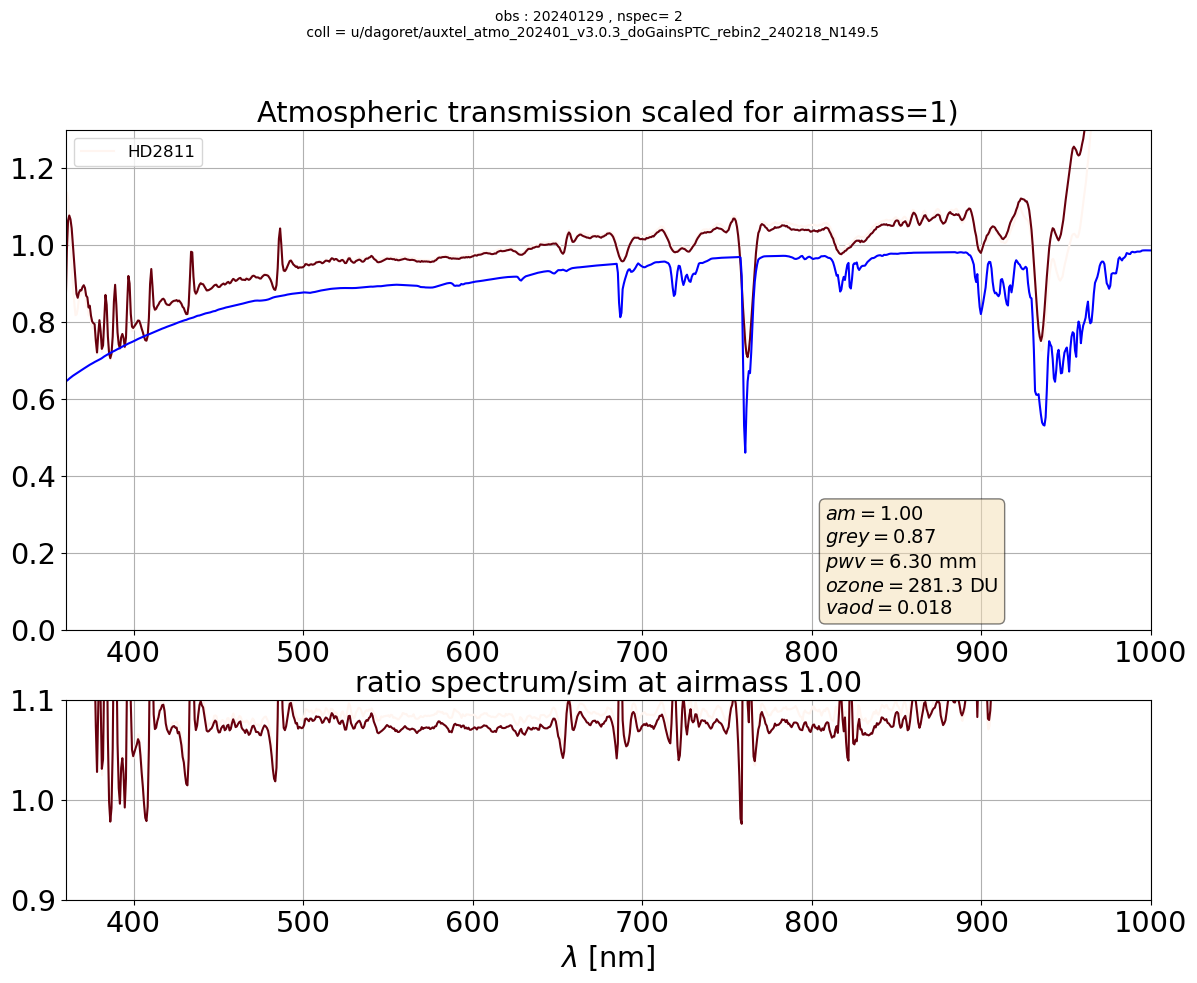

SKIP 1 20240130 []
>>> ID.     :  20240131 [2024013100293, 2024013100294]
>>> AIRMASS :  20240131 [1.00268647575224, 1.00299102212379]
>>>>   !!!! Exception plot_atmtransmission_zcorr_antatmsim_ratio !!!!
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


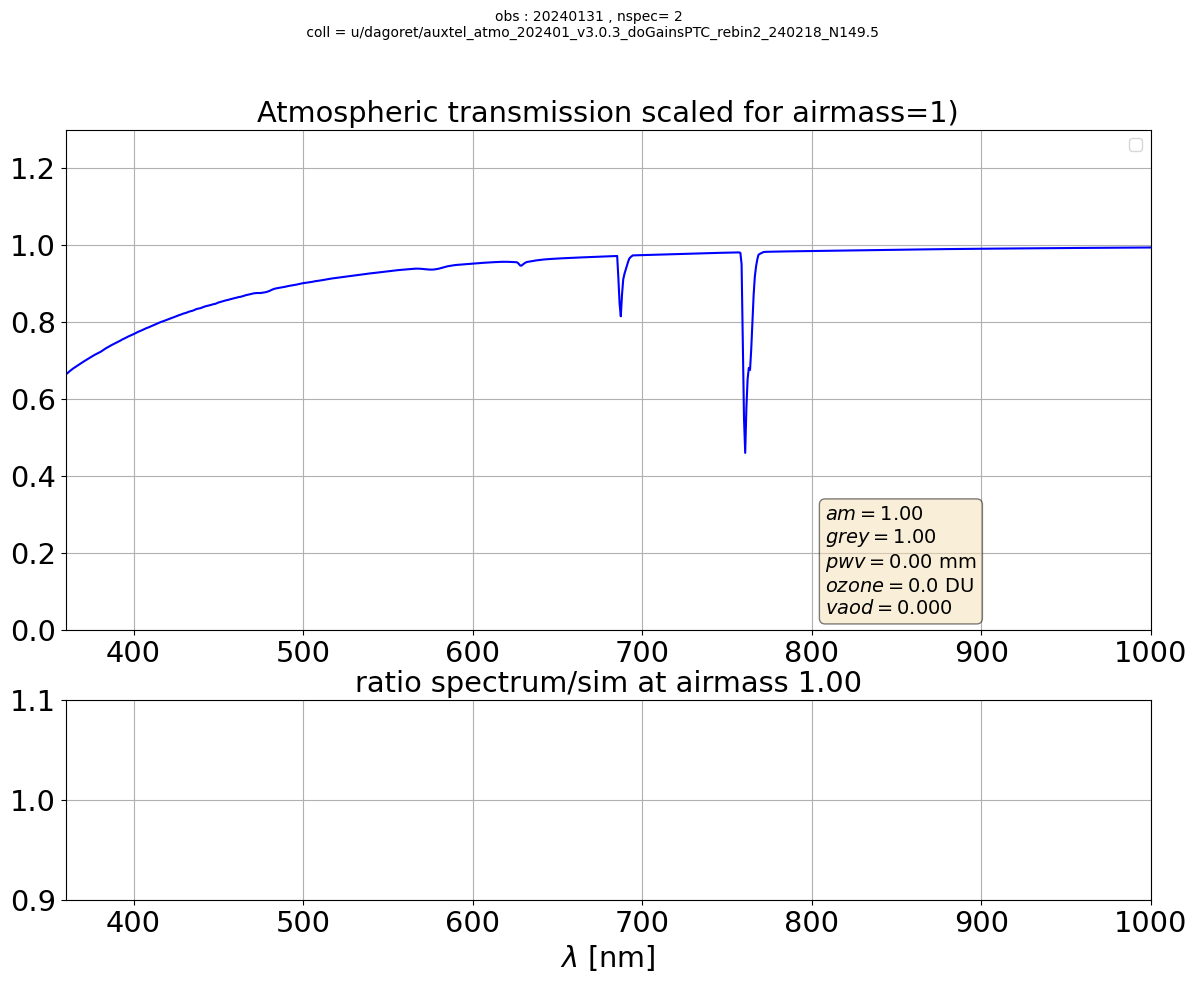

>>> ID.     :  20240205 [2024020500034, 2024020500041]
>>> AIRMASS :  20240205 [2.08863387672932, 2.02591865462175]
>>>>   !!!! Exception plot_atmtransmission_zcorr_antatmsim_ratio !!!!
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


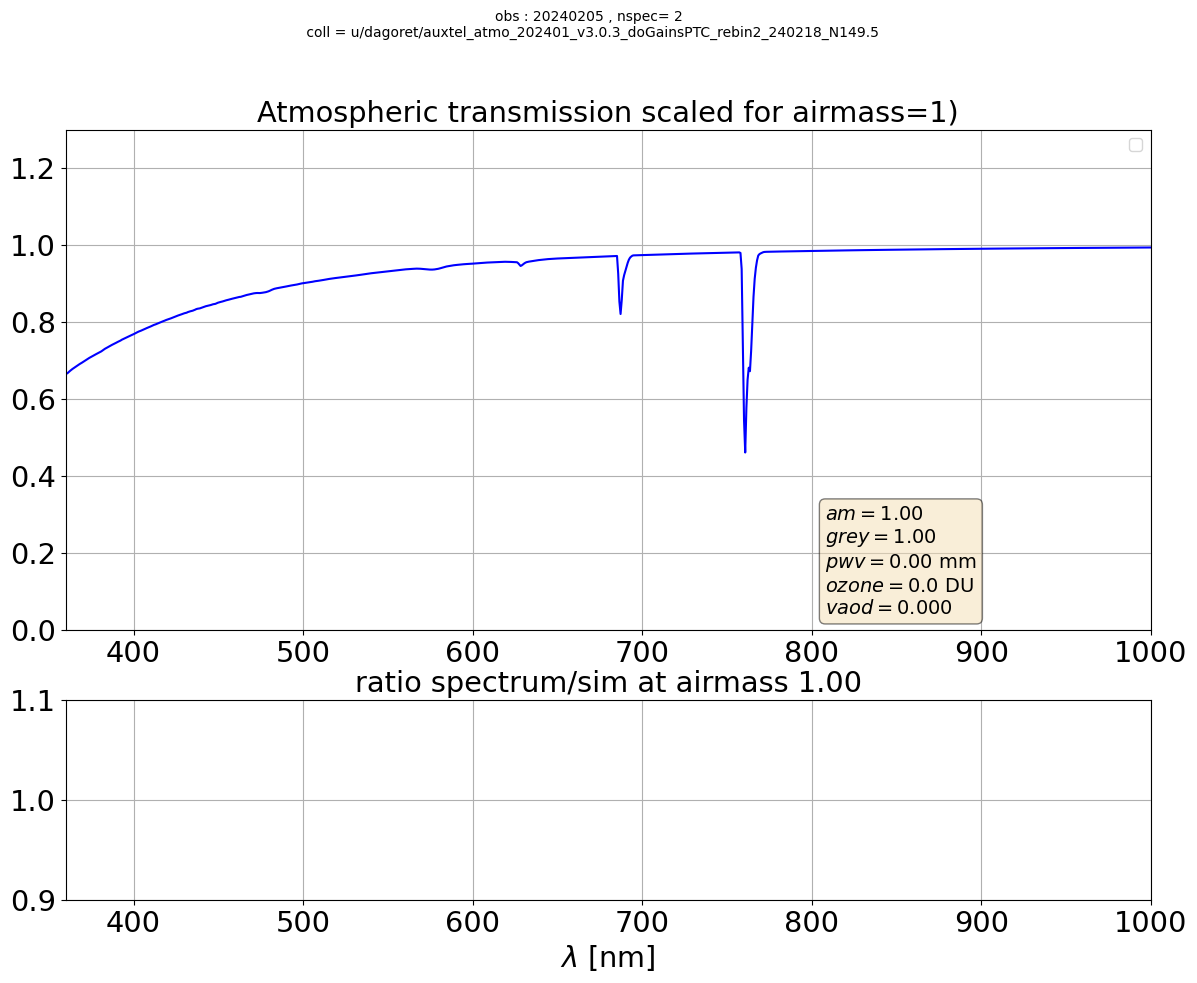

>>> ID.     :  20240206 [2024020600201, 2024020600202, 2024020600282, 2024020600283, 2024020600350]
>>> AIRMASS :  20240206 [2.14006382658196, 2.13983759061313, 2.10923875284958, 2.10866911575156, 2.05559801856528]
>>>>   !!!! Exception plot_atmtransmission_zcorr_antatmsim_ratio !!!!
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


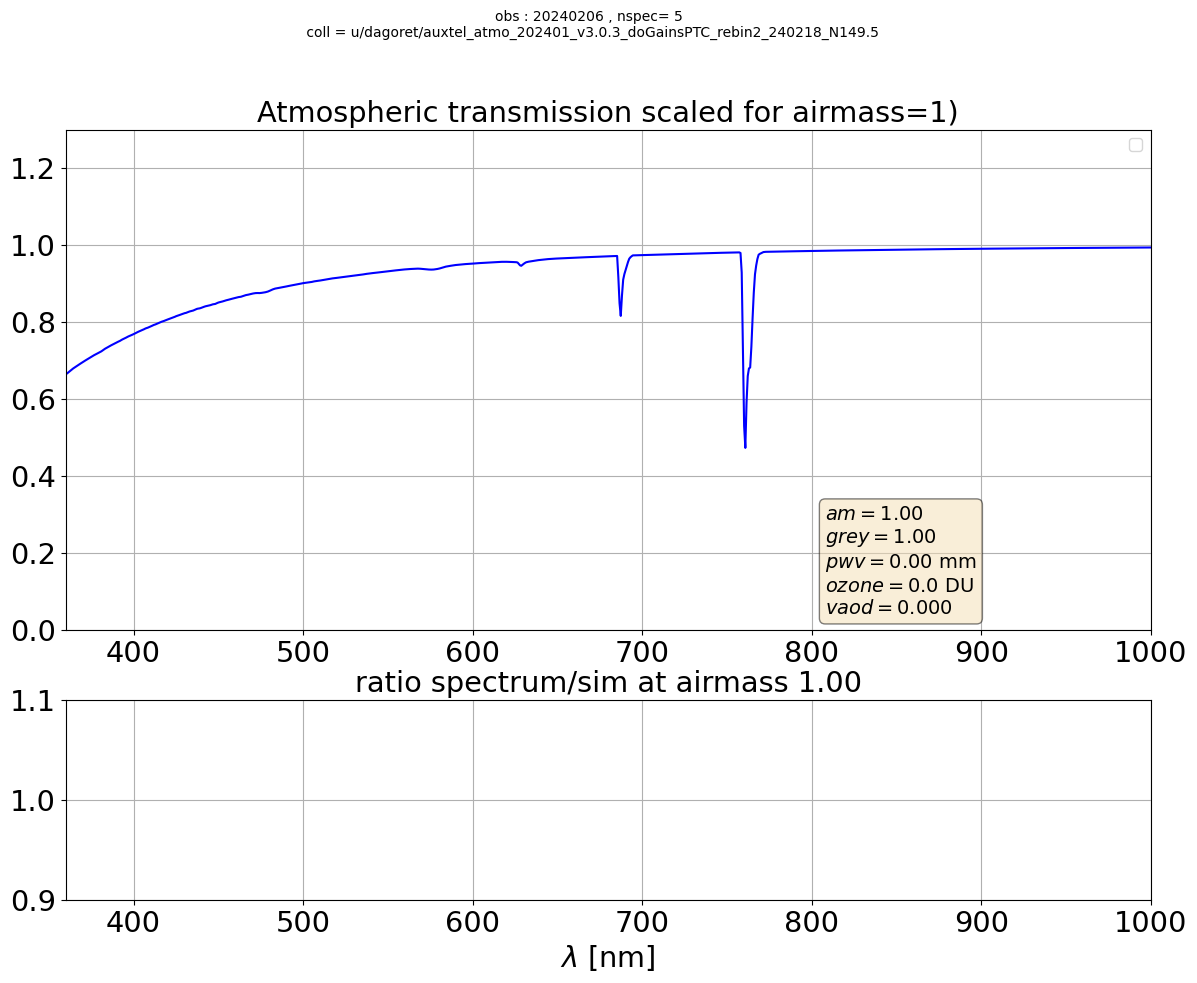

>>> ID.     :  20240207 [2024020700405, 2024020700411, 2024020700412]
>>> AIRMASS :  20240207 [1.24278021617035, 2.14448264299641, 2.14443464271158]
 mean parameters 0.5432198132849018 288.93915064654124 10.0 0.026167671027535935
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


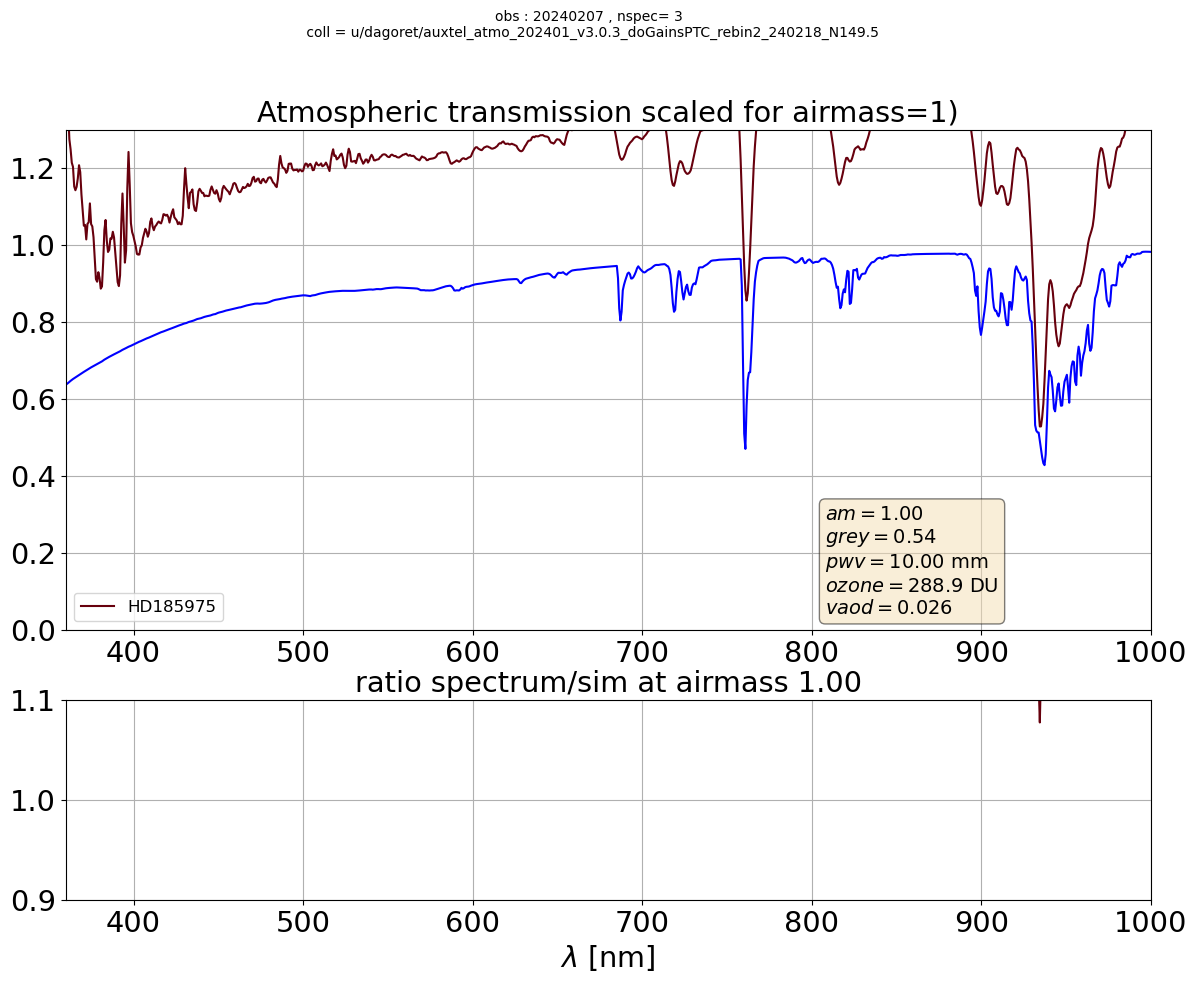

>>> ID.     :  20240212 [2024021200421, 2024021200526, 2024021200527, 2024021200593, 2024021200594]
>>> AIRMASS :  20240212 [2.10360324213764, 2.08597342399531, 2.08527901021243, 2.04624618434573, 2.04544278114646]
 mean parameters 0.9459249118868985 268.2371225252475 7.61676493982097 0.0
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


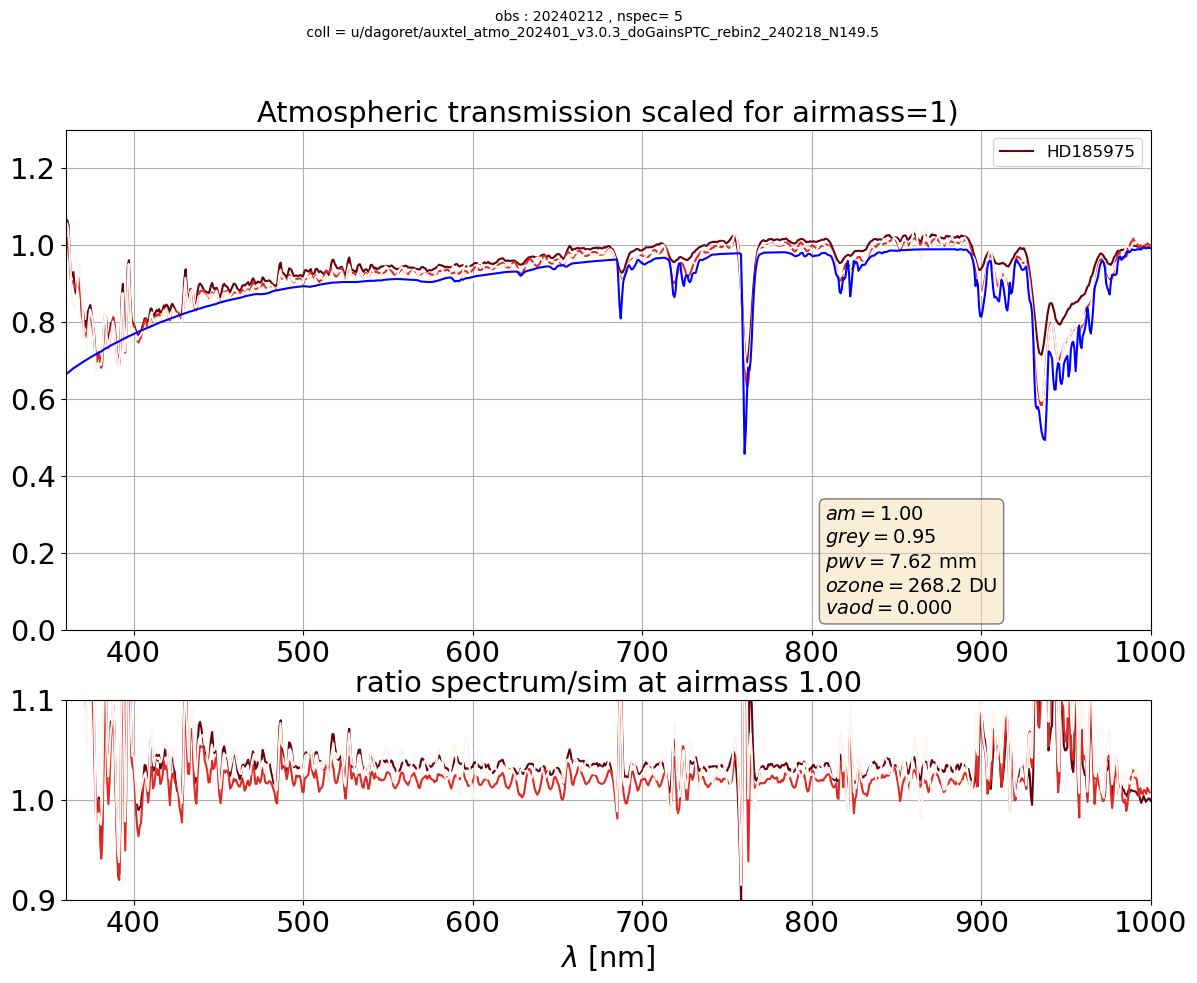

>>> ID.     :  20240213 [2024021300094, 2024021300108, 2024021300124, 2024021300151, 2024021300152, 2024021300182, 2024021300183]
>>> AIRMASS :  20240213 [1.30743272611362, 1.35761377221221, 1.50371940496777, 1.67093745320158, 1.67665053148208, 2.26521865924235, 2.27668485298832]
>>>>   !!!! Exception plot_atmtransmission_zcorr_antatmsim_ratio !!!!
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


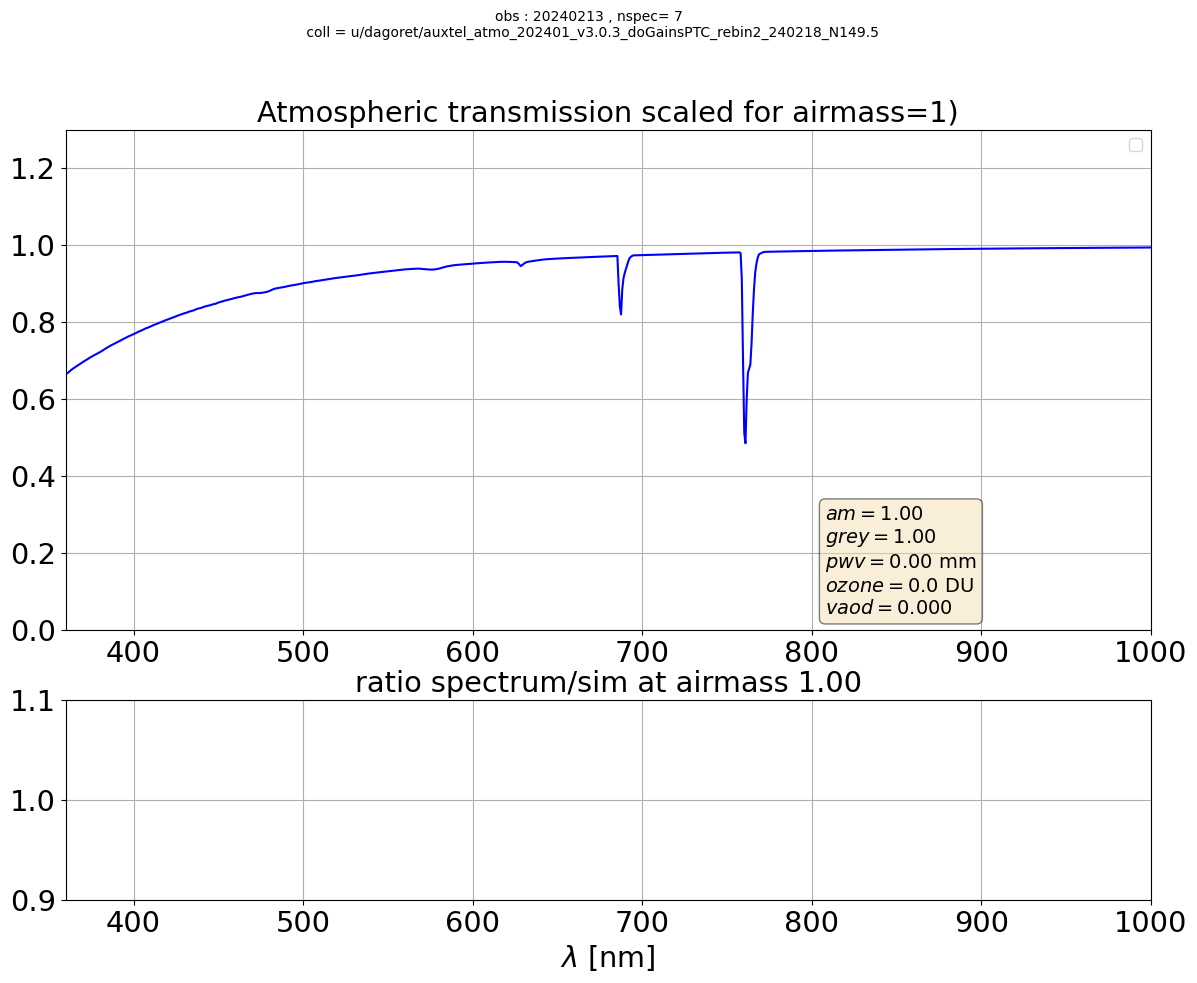

>>> ID.     :  20240214 [2024021400068, 2024021400076, 2024021400101, 2024021400102, 2024021400115, 2024021400130, 2024021400136, 2024021400137]
>>> AIRMASS :  20240214 [1.20509327449489, 1.22522104568144, 1.34225261342444, 1.34537236963363, 1.40803868249362, 1.55812360098439, 1.59391100732693, 1.59898717749373]
>>>>   !!!! Exception plot_atmtransmission_zcorr_antatmsim_ratio !!!!
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


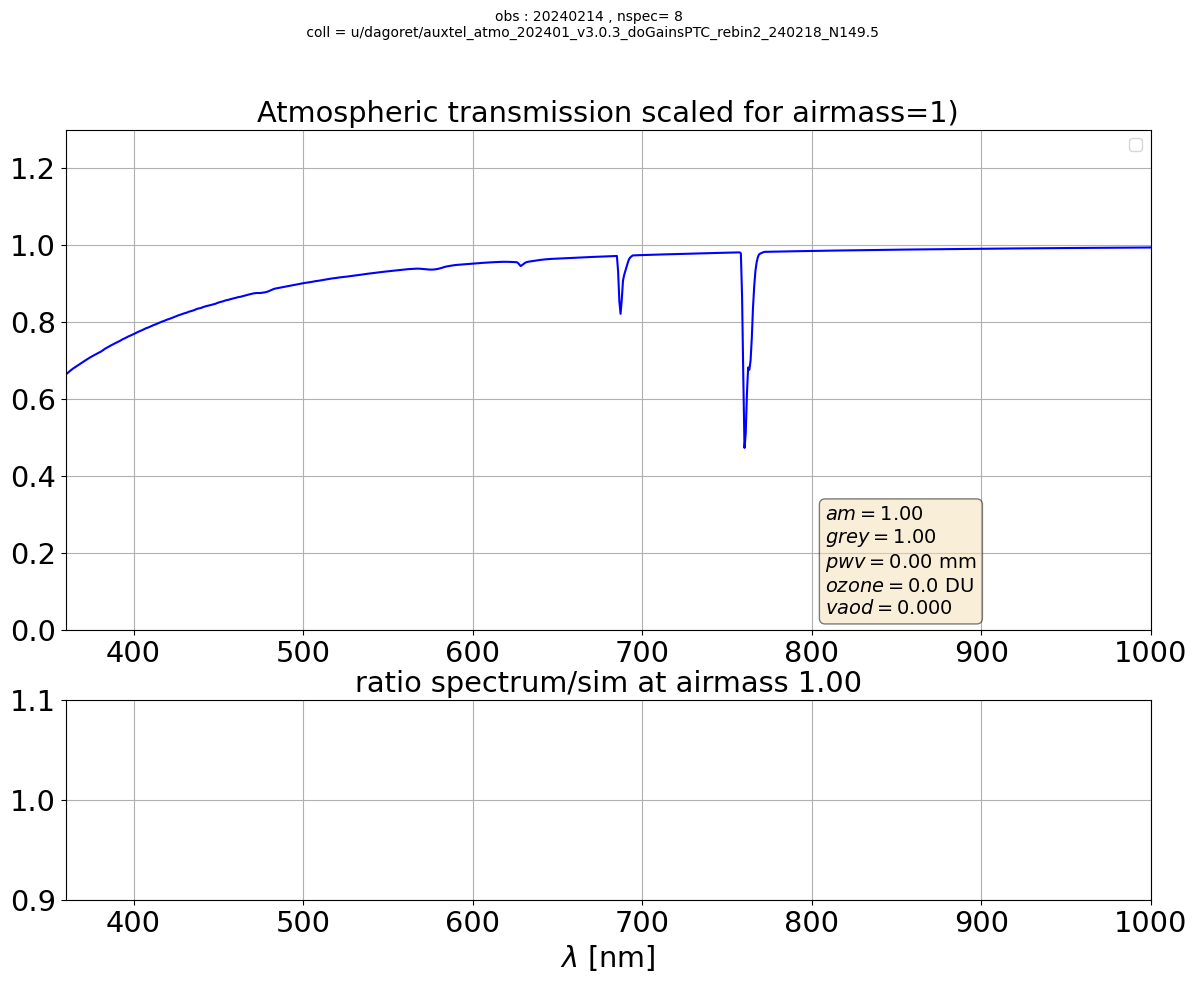

>>> ID.     :  20240215 [2024021500246]
>>> AIRMASS :  20240215 [2.1223544654735]
 
 /////// SKIPP 2024021500246 



In [68]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]

    N = len(selected_ids)

    if N ==0:
        print("SKIP",idx,DATEOBS,selected_ids)
        continue
        
    cut = (df.id == selected_ids[0])
    
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    

    if N> 1:   
        plot_atmtransmission_zcorr_antatmsim_ratio(filtered_spectra, [spec.airmass for spec in filtered_spectra],
                                                    all_calspecs_sm,tel,disp,collection = my_collection,dateobs=DATEOBS, df_atm = df_sel )
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")            

## Save in HDF5

In [69]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]

    N = len(selected_ids)

    if N ==0:
        print("SKIP",idx,DATEOBS,selected_ids)
        continue
        
    cut = (df.id == selected_ids[0])
    
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    

    if N> 1:   
        savehdf5_atmtransmission_zcorr_antatmsim_ratio(filtered_spectra, [spec.airmass for spec in filtered_spectra],
                                                    all_calspecs_sm,tel,disp,collection = my_collection,dateobs=DATEOBS, df_atm = df_sel)
        #plot_atmtransmission_zcorr_antatmsim_ratio(filtered_spectra, [spec.airmass for spec in filtered_spectra],
        #                                            all_calspecs_sm,tel,disp,collection = my_collection,dateobs=DATEOBS, df_atm = df_sel )
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")    

>>> ID.     :  20240129 [2024012900330, 2024012900331]
>>> AIRMASS :  20240129 [2.24640079579726, 2.26304847010233]
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory
>>>> create file spectra_transmission_ratio_20240129.h5
>>>> create group median_param_atm
 mean parameters 0.8710186953997314 281.29755329976575 6.298323979167375 0.01780571949057626
>>>> create group spec_2024012900330
>>>> create group spec_2024012900331
>>>> create group sim_spec
SKIP 1 20240130 []
>>> ID.     :  20240131 [2024013100293, 2024013100294]
>>> AIRMASS :  20240131 [1.00268647575224, 1.00299102212379]
AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory
>>>> create file spectra_transmission_ratio_20240131.h5
>>>> create group median_param_atm
>>>>   !!!! savehdf5_atmtransmission_zcorr_antatmsim_ratio !!!!
<class 'ValueError'>
('too many values to unpack (expected 4)',)
too many values to unpack (expected 4)
>>>> create group

# Total transmission and zero points

In [70]:
def compute_total_transm(filter,meas_atmtransm):
    """
    """
    N = len(meas_atmtransm)
    bd = bandpass_inst[filter]
    func = interpolate.interp1d(x=bd.wavelen, y=bd.sb ,fill_value="extrapolate")
    all_total_transm = []
    for idx in range(N):
        the_wl = meas_atmtransm[idx][0]
        the_atm = meas_atmtransm[idx][1]
        the_totaltrans = the_atm * func(the_wl)
        all_total_transm.append((the_wl,the_totaltrans))
    return all_total_transm

In [71]:
all_all_total_transm = []
all_selectednights = []

# loop on all transmission of a given night
for idx,  all_meas_atmtransmissions_z1 in enumerate(allall_meas_atmtransmissions_z1): 
    DATEOBS = ALL_DATEOBS[idx]

    if len(all_meas_atmtransmissions_z1)>1:
        all_selectednights.append(True) 
        all_total_transm = {} 
        # loop on filters
        for index,f in enumerate(filter_tagnames):
            all_total_transm[f] = compute_total_transm(f,all_meas_atmtransmissions_z1)
        
        all_all_total_transm.append(all_total_transm )
    else:
        all_all_total_transm.append({})
        all_selectednights.append(False) 
        

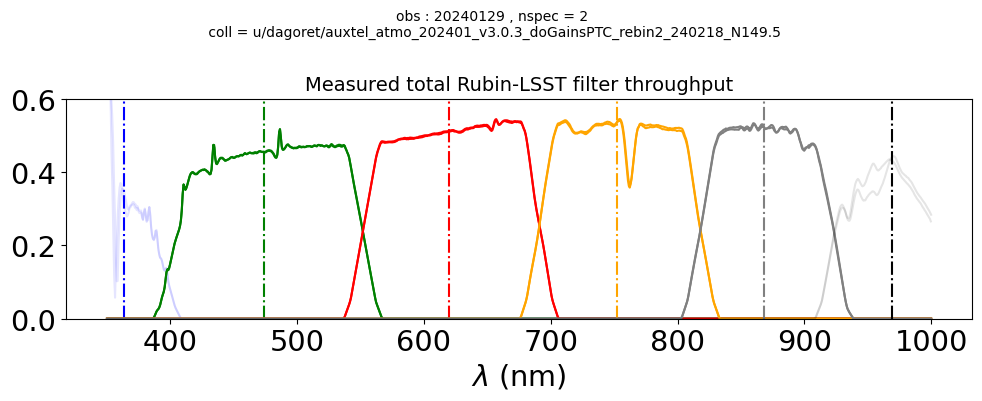

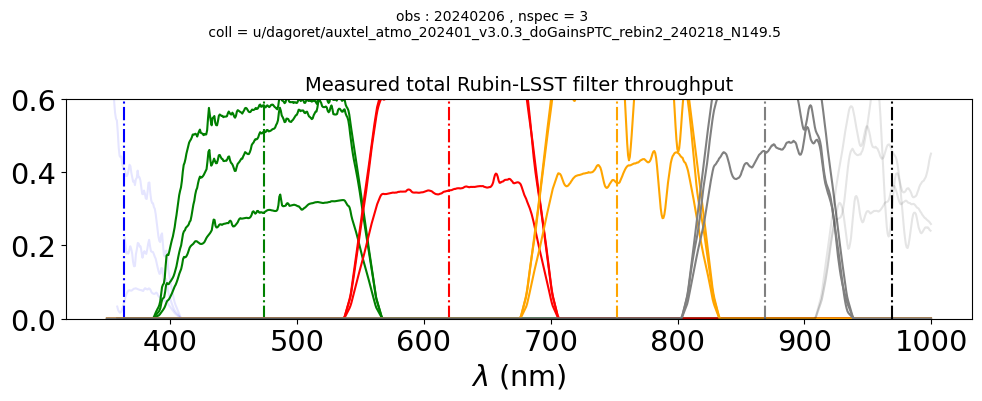

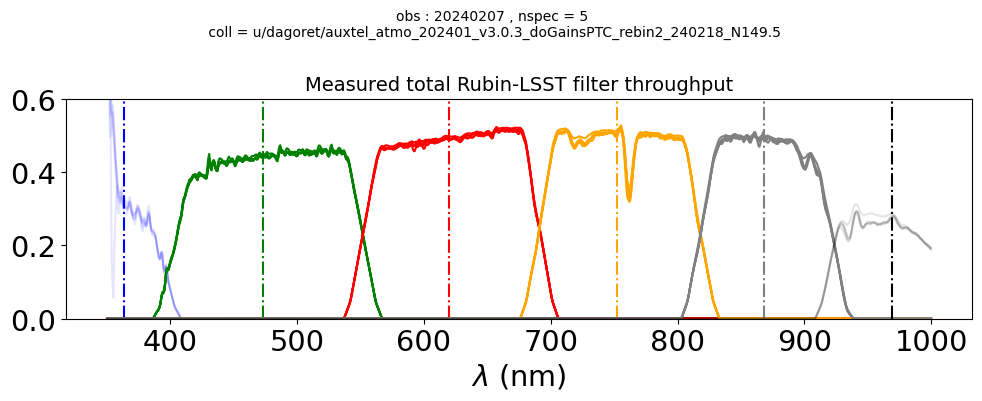

In [72]:
for idx0,all_total_transm in enumerate(all_all_total_transm):
    
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:
    

        fig, axs = plt.subplots(1,1,figsize=(10,4))
        for index,f in enumerate(filter_tagnames):
    
            N = len(all_total_transm[f])
            for idx in range(N):
                the_wl = all_total_transm[f][idx][0] 
                the_tottransm = all_total_transm[f][idx][1] 
                if index==0 or index==5:
                    axs.plot(the_wl,the_tottransm ,color=filter_color[index],alpha=0.1) 
                else:
                    axs.plot(the_wl,the_tottransm ,color=filter_color[index]) 
            axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
        axs.set_xlabel("$\\lambda$ (nm)")
        axs.set_title("Measured total Rubin-LSST filter throughput",fontsize=14)
        axs.set_ylim(0,0.6)
        suptitle = f"obs : {DATEOBS} , nspec = {N}\n coll = {my_collection}"
        plt.suptitle(suptitle,fontsize=10,y=1.0)
        plt.tight_layout()
        plt.show()    

### Compute integrals

In [73]:
all_all_total_II0 = []
#all_all_total_II0_mjd = []


# loop on dates
for idx0,all_total_transm in enumerate(all_all_total_transm):
    
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:
        
        all_total_II0 = {} 
   
        for index,f in enumerate(filter_tagnames):
    
            N = len(all_total_transm[f])
            all_II0 = np.zeros(N)
                
            for idx in range(N):
                the_wl = all_total_transm[f][idx][0] 
                the_tottransm = all_total_transm[f][idx][1] 
                #print( DATEOBS,f,idx,N,len(the_wl),the_tottransm.min(),the_tottransm.max())
                
                try:    
                    all_II0[idx] = fII0(the_wl,the_tottransm)
                except Exception as inst:
                    print(f">>>> Exception in {DATEOBS}, filter {f} , idx = {idx}/{N}")
                    print(type(inst))    # the exception type
                    print(inst.args)     # arguments stored in .args
                    print(inst)          # __str__ allows args to be printed directly,
                    # if calculation fails, put a NaN
                    all_II0[idx] = np.nan

            # remove NaN
            all_total_II0[f] = all_II0[~np.isnan(all_II0)]
            
        all_all_total_II0.append(all_total_II0)
         
    else:
        all_all_total_II0.append({})
       
        
        

In [74]:
np.nan

nan

In [75]:
all_zp = []

for idx0, all_total_II0 in enumerate(all_all_total_II0):
    
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:
        zp = {}
        for index,f in enumerate(filter_tagnames):
            zp[f] = 2.5*np.log10(all_total_II0[f]) 
        
        all_zp.append(zp)
    else:
        all_zp.append({})

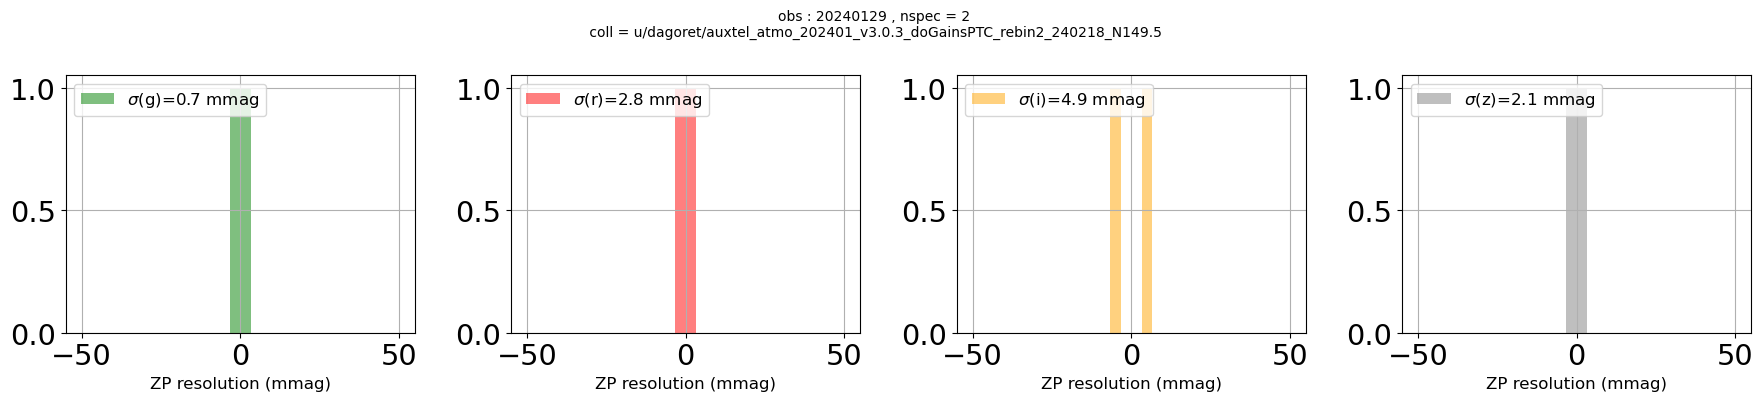

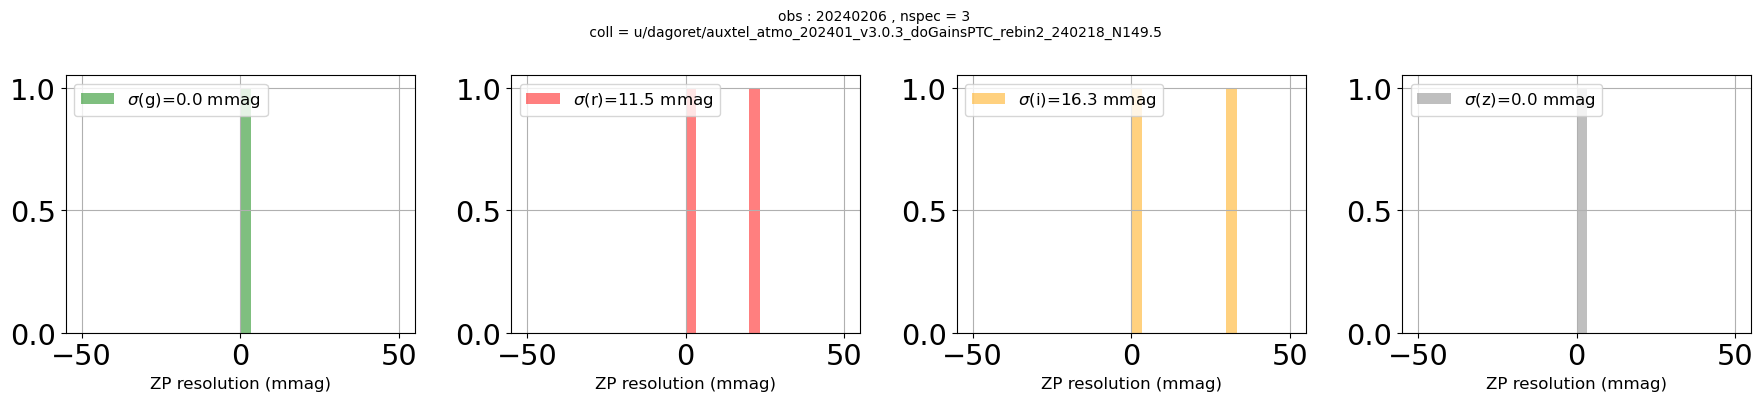

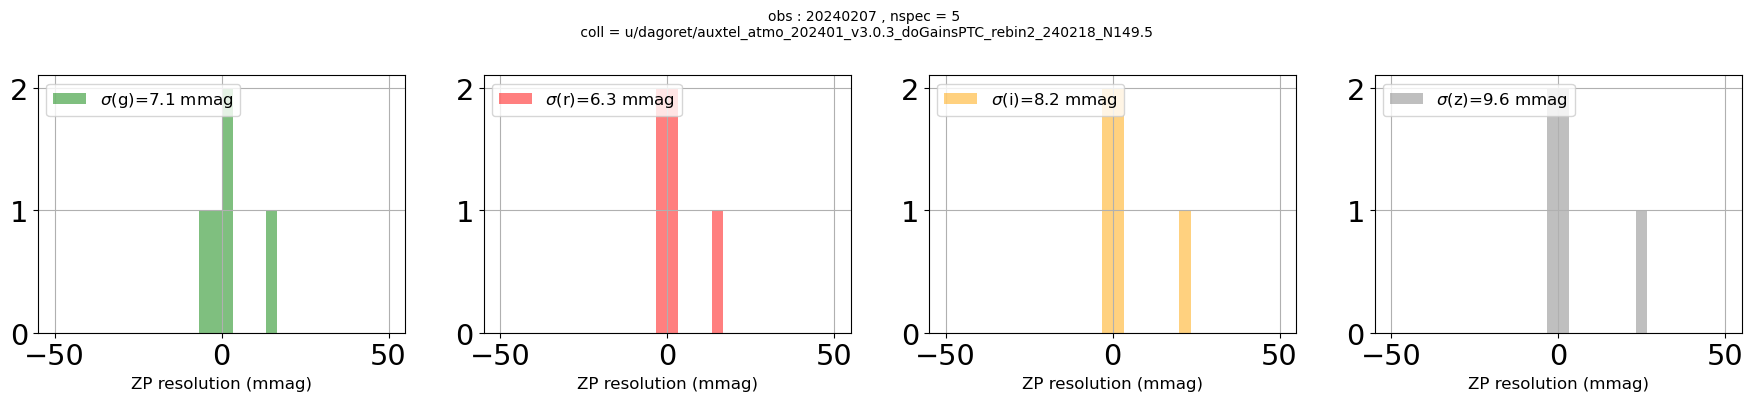

In [76]:
for idx0, zp in enumerate(all_zp):
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:

        fig, axs = plt.subplots(1,4,figsize=(18,4))
        for index,f in enumerate(filter_tagnames):
            if index==0 or index==5:
                continue
            X = (zp[f] - np.median(zp[f]))*1000.
            N = len(X)
            X = X[np.where(np.abs(X)<50)]
            std = np.std(X)
            label = f"$\sigma$({f})={std:.1f} mmag"
            axs[index-1].hist(X,bins=30,range=(-50,50),color=filter_color[index],alpha=0.5,label=label)
            axs[index-1].grid()
            #axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            axs[index-1].legend(loc='upper left')
            axs[index-1].set_xlabel("ZP resolution (mmag)",fontsize=12)
        suptitle = f"obs : {DATEOBS} , nspec = {N}\n coll = {my_collection}"
        plt.suptitle(suptitle,fontsize=10,y=1.0)
        plt.tight_layout()
        plt.show()

### Summary for zero point repeatability 

In [77]:
df_zp = pd.DataFrame(columns= ["dateobs","dZp_u","dZp_g","dZp_r","dZp_i","dZp_z","dZp_y"]) 
icount = 0
for idx0, zp in enumerate(all_zp):
    DATEOBS = ALL_DATEOBS[idx0]
    data = []
    
    if all_selectednights[idx0]:
        data.append(int(DATEOBS))
        for index,f in enumerate(filter_tagnames): 
            X = (zp[f] - np.median(zp[f]))*1000.
            N = len(X)
            X = X[np.where(np.abs(X)<50)]
            std = np.std(X)
            data.append(std)

        df_zp.loc[icount] = data
        icount +=1
            
           

In [78]:
df_zp

dateobs      dZp_u     dZp_g      dZp_r      dZp_i     dZp_z      dZp_y
0  20240129.0   1.701064  0.662330   2.813613   4.922696  2.130901  17.982258
1  20240206.0   0.000000  0.000000  11.492426  16.261091  0.000000   8.239576
2  20240207.0  19.465371  7.111987   6.265137   8.241993  9.582204   5.229299

In [79]:
df_zp.to_csv(file_out_zp)

In [80]:
def convertNumToDatestr(num):
    num = int(num)
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [81]:
df_zp["dateobsstr"] = df_zp["dateobs"].apply(convertNumToDatestr)

In [82]:
df_zp["datetime"] = pd.to_datetime(df_zp["dateobsstr"])

Text(0.5, 1.0, 'Repeatability of Zero point predicted by Auxtel Spectroscopy')

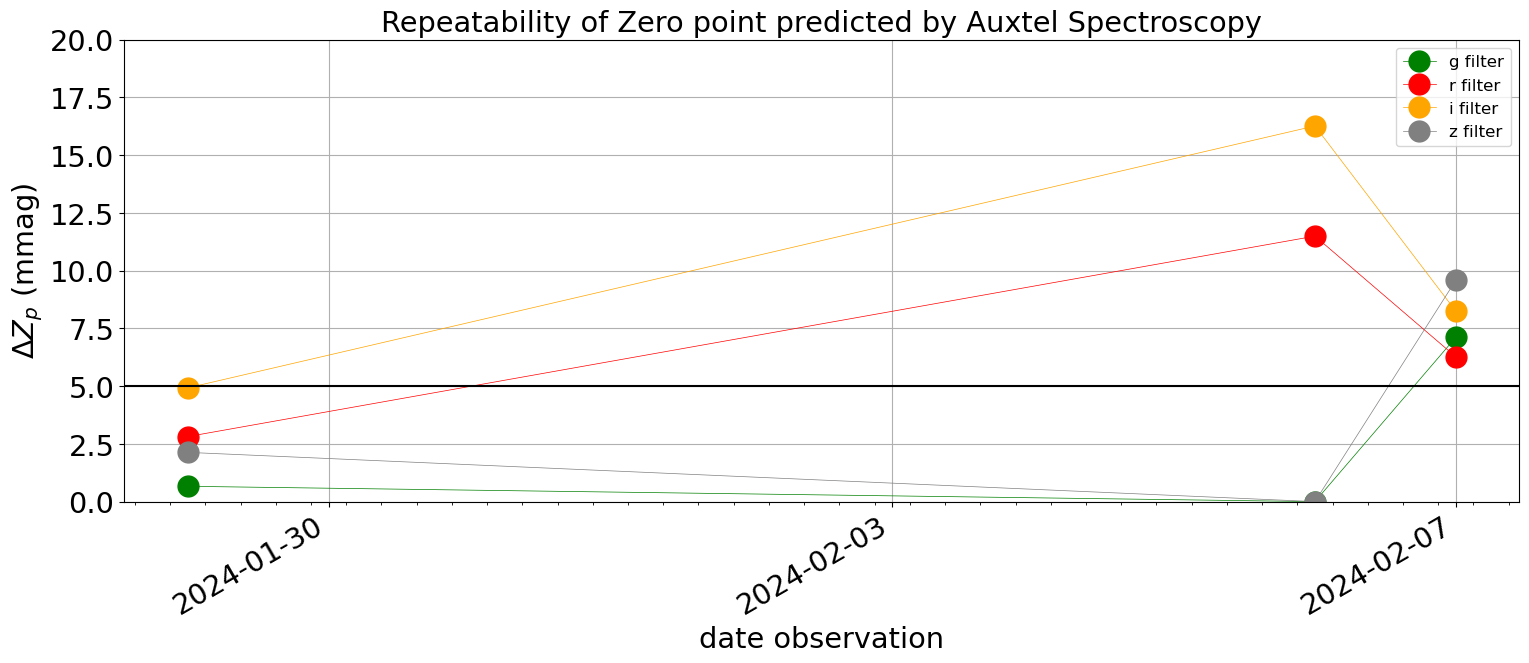

In [83]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=4)
hour_locator = mdates.HourLocator(interval=6)

fmt = '%D %H:%M:'
#year_month_formatter = mdates.DateFormatter(fmt) 
year_month_formatter = mdates.DateFormatter("%Y-%m-%d") 

fig, ax = plt.subplots(1,1,figsize=(18, 6))

ax.plot(df_zp["datetime"],df_zp["dZp_g"],marker="o",ms=15,color="g",lw=0.5,label="g filter")
ax.plot(df_zp["datetime"],df_zp["dZp_r"],marker="o",ms=15,color="r",lw=0.5,label="r filter")
ax.plot(df_zp["datetime"],df_zp["dZp_i"],marker="o",ms=15,color="orange",lw=0.5,label="i filter")
ax.plot(df_zp["datetime"],df_zp["dZp_z"],marker="o",ms=15,color="grey",lw=0.5,label="z filter")
ax.legend()
#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_major_locator(day_locator)
ax.xaxis.set_minor_locator(hour_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
ax.grid()
ax.set_ylim(0.,20.)
ax.axhline(5,color="k")
ax.set_xlabel("date observation")
ax.set_ylabel("$\Delta Z_p$ (mmag)")
ax.set_title("Repeatability of Zero point predicted by Auxtel Spectroscopy")